In [1]:
%matplotlib inline

import numpy as np
import copy


import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.1
seed 4
2023-07-27 20:31:51.675294


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-6.9585)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-4.0745)
penalty_target_min tensor(-11.4734) penalty_target_max tensor(41.5777)
train_loss:  -7.916378908348084
valid_loss:  -7.248065069580079
h_min_tilde -11.473402 ell_tilde -7.7827161405944825 kappa_tilde 0.0005205308314289548


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 1.6689300537109375e-06


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 3.7118194103240967

 2 3.4473938941955566

 3 3.2212605476379395

 4 3.2365427017211914

 5 3.244224786758423

 6 3.2942609786987305

 7 3.2990665435791016

 8 3.266664743423462

 9 3.2766902446746826

 10 3.2468292713165283

 11 3.2642364501953125

 12 3.1662373542785645

 13 3.2174675464630127

 14 3.3001067638397217

 15 3.226047992706299

 16 3.115002393722534

 17 3.129934549331665

 18 3.209775447845459

 19 3.1310973167419434

 20 3.192253589630127

 21 3.367776393890381

 22 3.175590991973877

 23 3.165379285812378

 24 3.186868190765381

 25 3.3614516258239746

 26 3.273162841796875

 27 3.2459516525268555

 28 3.311246871948242

 29 3.2718043327331543

 30 3.2204015254974365

 31 3.3744819164276123

 32 3.1581902503967285

 33 3.2026336193084717

 34 3.2390427589416504

 35 3.157762050628662

 36 3.177947759628296

 37 3.2549245357513428

 38 3.233166217803955

 39 3.1171021461486816

 40 3.195037603378296

 41 3.1824207305908203

 42 3.1420555114746094

 43 3.11927843093

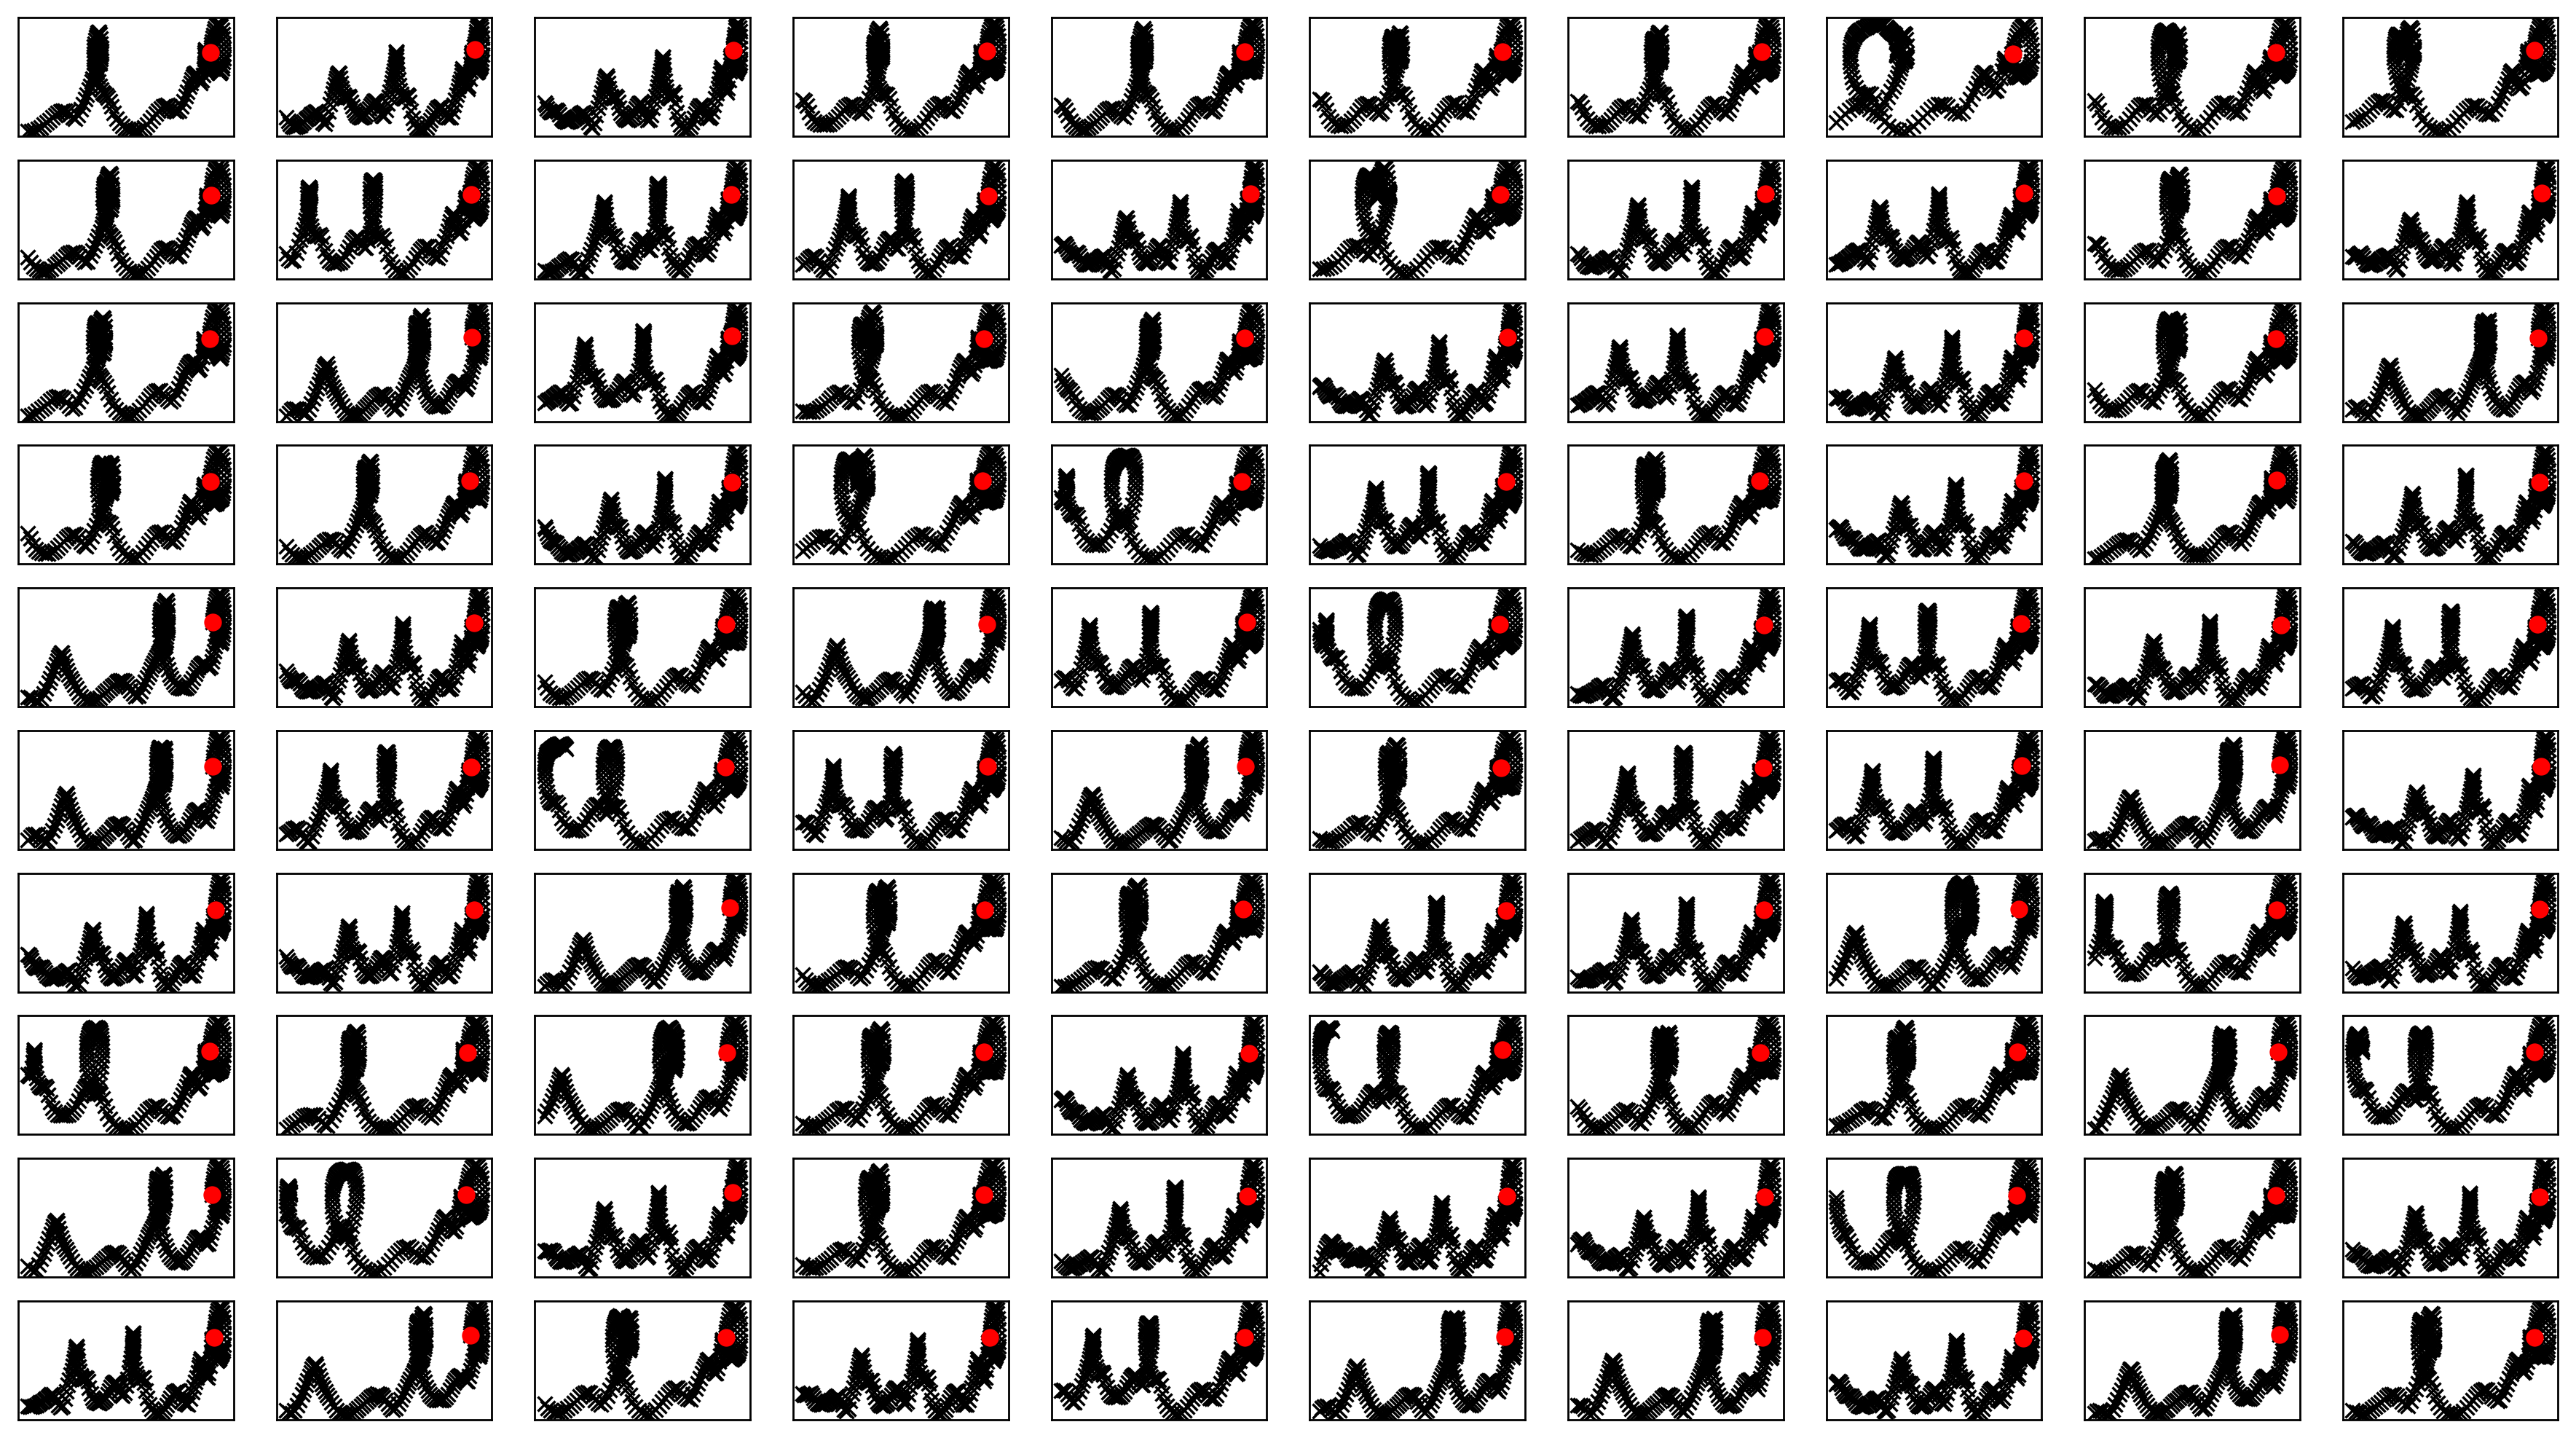

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

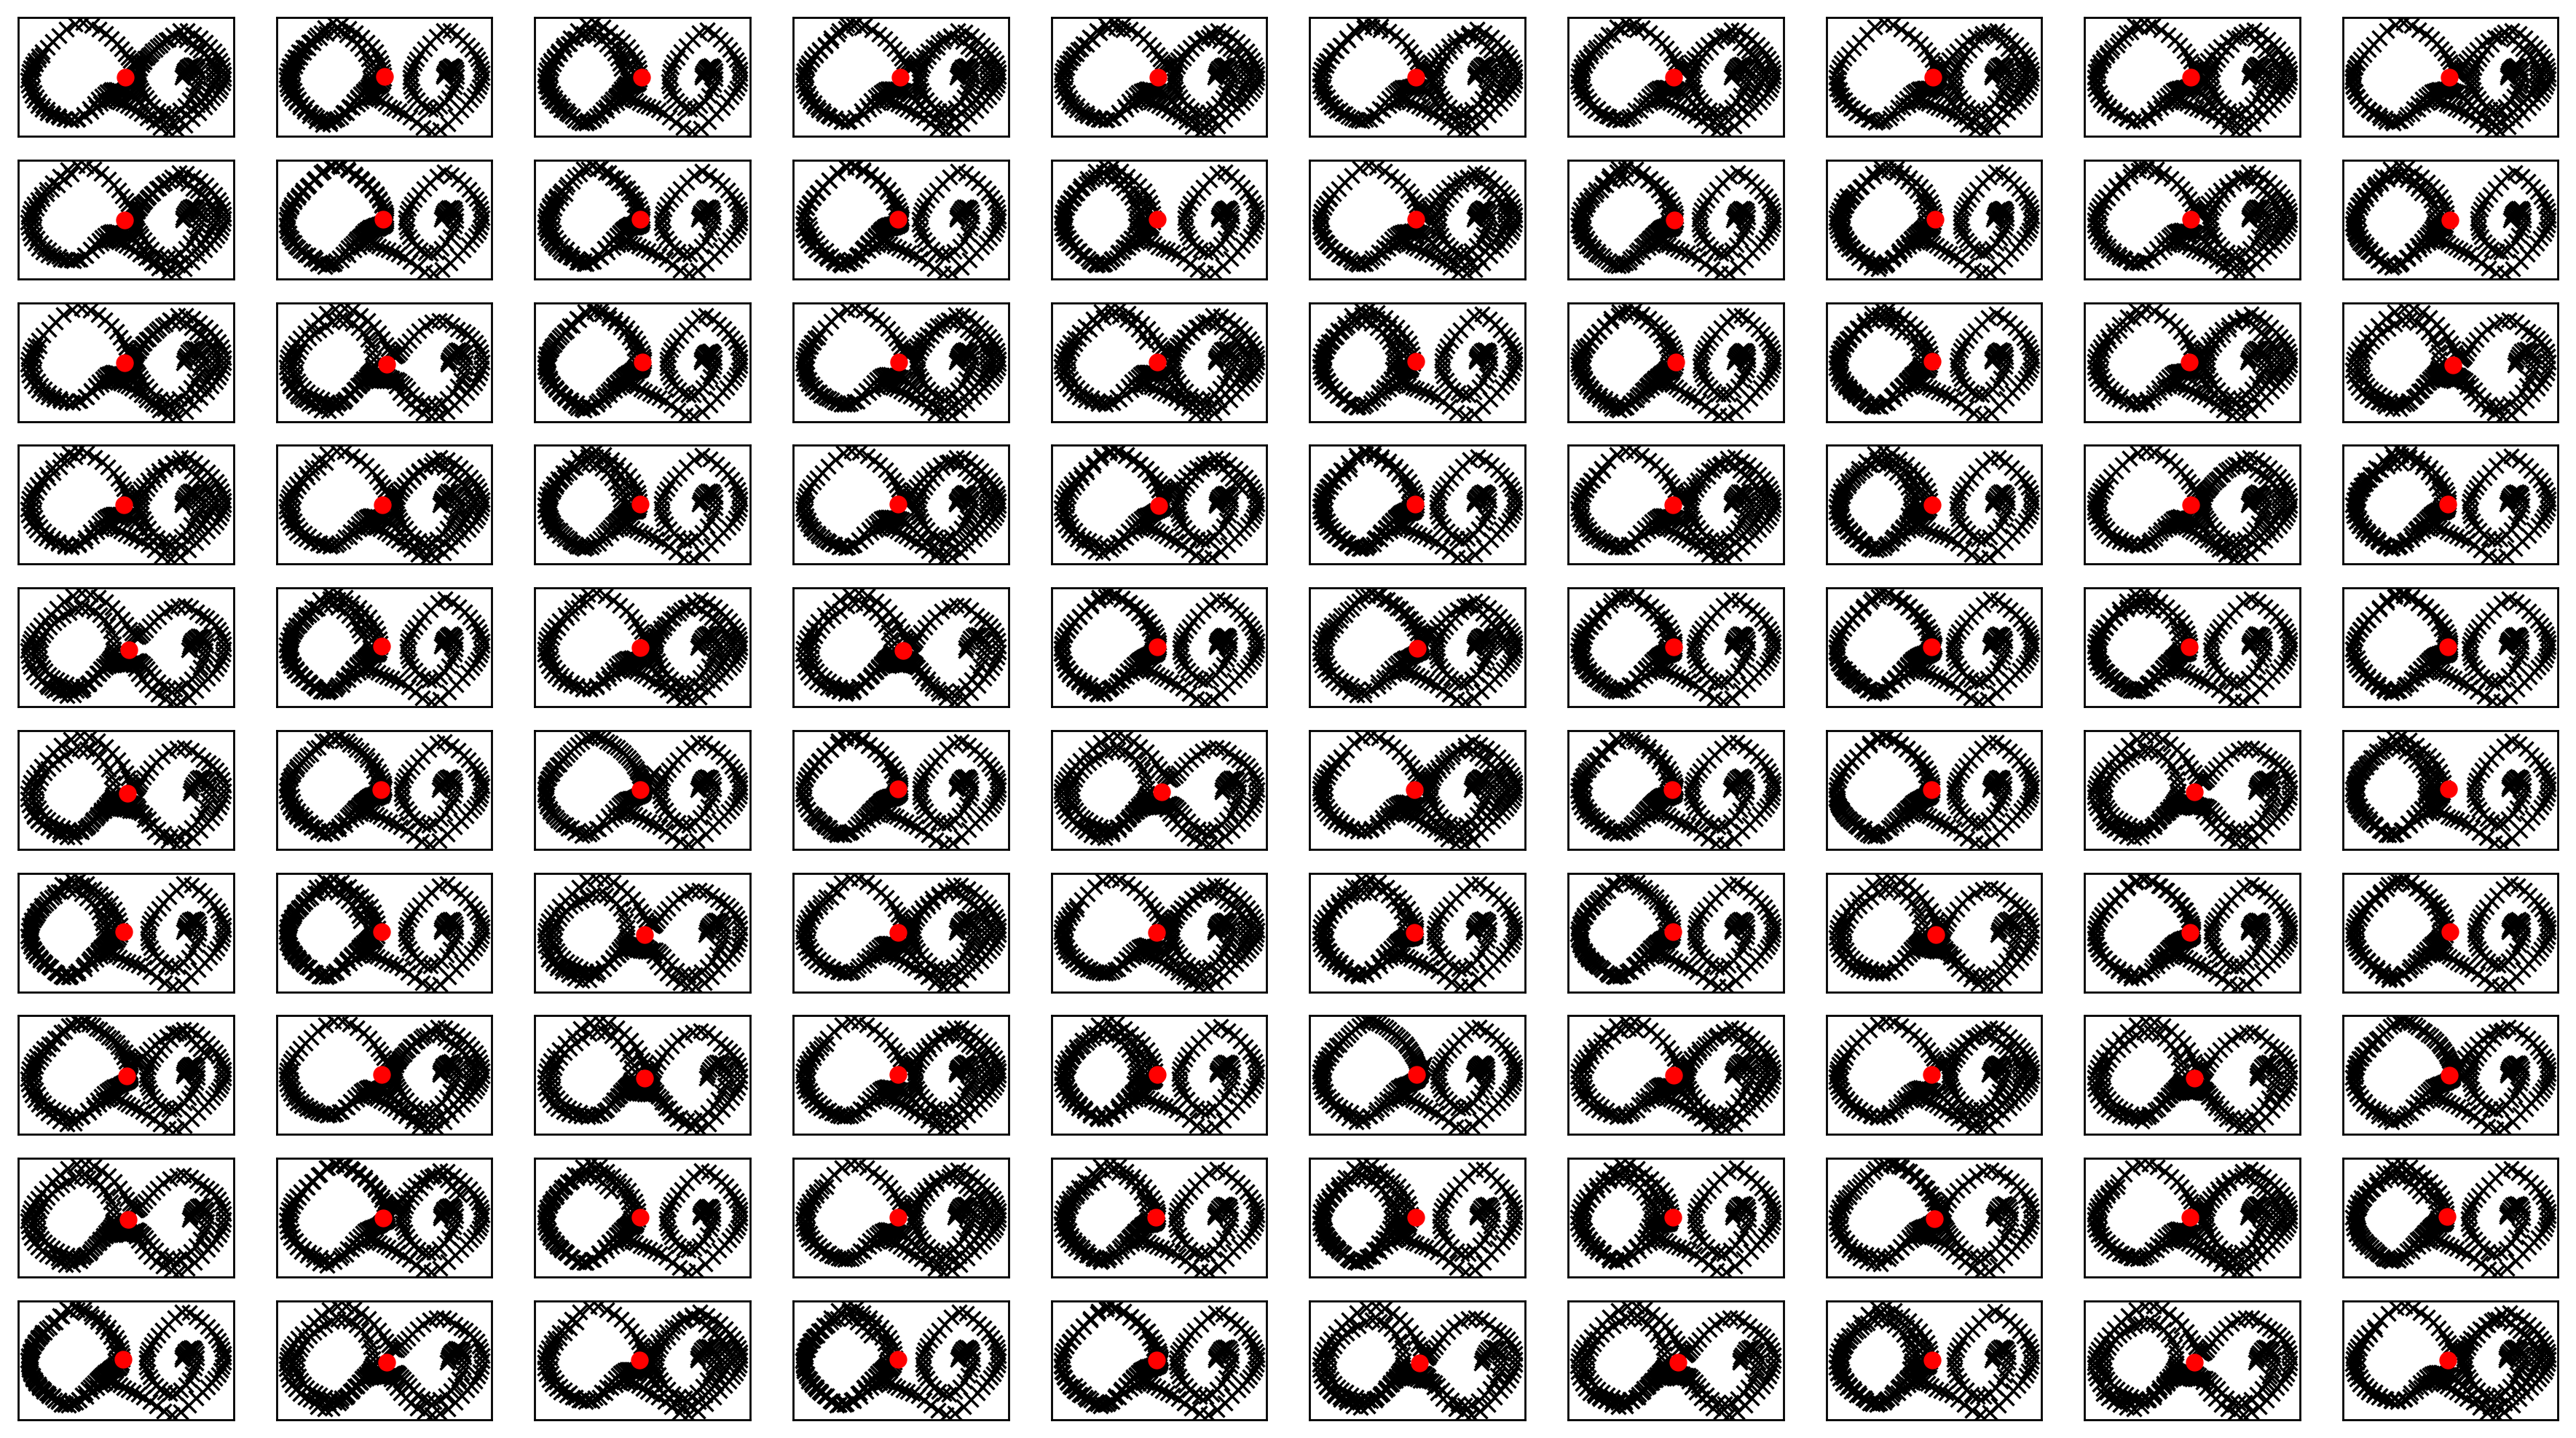

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-07-27 20:37:20.142686


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.33948  validloss 1.42818±0.00000  bestvalidloss 1.42818  last_update 0
train: iter 1  trainloss 1.23704  validloss 1.24403±0.00000  bestvalidloss 1.24403  last_update 0
train: iter 2  trainloss 1.14527  validloss 1.11694±0.00000  bestvalidloss 1.11694  last_update 0
train: iter 3  trainloss 1.03586  validloss 1.03824±0.00000  bestvalidloss 1.03824  last_update 0
train: iter 4  trainloss 0.95954  validloss 0.95872±0.00000  bestvalidloss 0.95872  last_update 0
train: iter 5  trainloss 0.90035  validloss 0.87987±0.00000  bestvalidloss 0.87987  last_update 0
train: iter 6  trainloss 0.87311  validloss 0.84513±0.00000  bestvalidloss 0.84513  last_update 0
train: iter 7  trainloss 0.83232  validloss 0.80866±0.00000  bestvalidloss 0.80866  last_update 0
train: iter 8  trainloss 0.79923  validloss 0.77759±0.00000  bestvalidloss 0.77759  last_update 0
train: iter 9  trainloss 0.77928  validloss 0.75499±0.00000  bestvalidloss 0.75499  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.51003  validloss 0.51303±0.00000  bestvalidloss 0.50032  last_update 1
train: iter 84  trainloss 0.50686  validloss 0.49684±0.00000  bestvalidloss 0.49684  last_update 0
train: iter 85  trainloss 0.51012  validloss 0.51447±0.00000  bestvalidloss 0.49684  last_update 1
train: iter 86  trainloss 0.50507  validloss 0.50081±0.00000  bestvalidloss 0.49684  last_update 2
train: iter 87  trainloss 0.50114  validloss 0.50823±0.00000  bestvalidloss 0.49684  last_update 3
train: iter 88  trainloss 0.50326  validloss 0.49468±0.00000  bestvalidloss 0.49468  last_update 0
train: iter 89  trainloss 0.50938  validloss 0.50327±0.00000  bestvalidloss 0.49468  last_update 1
train: iter 90  trainloss 0.50656  validloss 0.49907±0.00000  bestvalidloss 0.49468  last_update 2
train: iter 91  trainloss 0.50171  validloss 0.49073±0.00000  bestvalidloss 0.49073  last_update 0
train: iter 92  trainloss 0.50502  validloss 0.50230±0.00000  bestvalidloss 0.49073  last_update 1
train: ite

train: iter 166  trainloss 0.45608  validloss 0.48578±0.00000  bestvalidloss 0.46604  last_update 4
train: iter 167  trainloss 0.46101  validloss 0.46887±0.00000  bestvalidloss 0.46604  last_update 5
train: iter 168  trainloss 0.46712  validloss 0.47466±0.00000  bestvalidloss 0.46604  last_update 6
train: iter 169  trainloss 0.46812  validloss 0.49172±0.00000  bestvalidloss 0.46604  last_update 7
train: iter 170  trainloss 0.45983  validloss 0.47871±0.00000  bestvalidloss 0.46604  last_update 8
train: iter 171  trainloss 0.45815  validloss 0.47766±0.00000  bestvalidloss 0.46604  last_update 9
train: iter 172  trainloss 0.45345  validloss 0.46792±0.00000  bestvalidloss 0.46604  last_update 10
train: iter 173  trainloss 0.46781  validloss 0.49243±0.00000  bestvalidloss 0.46604  last_update 11
train: iter 174  trainloss 0.45714  validloss 0.49324±0.00000  bestvalidloss 0.46604  last_update 12
train: iter 175  trainloss 0.45531  validloss 0.46201±0.00000  bestvalidloss 0.46201  last_update

train: iter 248  trainloss 0.43370  validloss 0.46244±0.00000  bestvalidloss 0.44398  last_update 4
train: iter 249  trainloss 0.43425  validloss 0.45617±0.00000  bestvalidloss 0.44398  last_update 5
train: iter 250  trainloss 0.43389  validloss 0.45708±0.00000  bestvalidloss 0.44398  last_update 6
train: iter 251  trainloss 0.43158  validloss 0.45213±0.00000  bestvalidloss 0.44398  last_update 7
train: iter 252  trainloss 0.43018  validloss 0.48618±0.00000  bestvalidloss 0.44398  last_update 8
train: iter 253  trainloss 0.43418  validloss 0.44172±0.00000  bestvalidloss 0.44172  last_update 0
train: iter 254  trainloss 0.43064  validloss 0.44612±0.00000  bestvalidloss 0.44172  last_update 1
train: iter 255  trainloss 0.42380  validloss 0.44134±0.00000  bestvalidloss 0.44134  last_update 0
train: iter 256  trainloss 0.42465  validloss 0.44203±0.00000  bestvalidloss 0.44134  last_update 1
train: iter 257  trainloss 0.42899  validloss 0.43951±0.00000  bestvalidloss 0.43951  last_update 0


train: iter 331  trainloss 0.40706  validloss 0.43409±0.00000  bestvalidloss 0.42678  last_update 2
train: iter 332  trainloss 0.40508  validloss 0.44298±0.00000  bestvalidloss 0.42678  last_update 3
train: iter 333  trainloss 0.40903  validloss 0.45441±0.00000  bestvalidloss 0.42678  last_update 4
train: iter 334  trainloss 0.40396  validloss 0.45271±0.00000  bestvalidloss 0.42678  last_update 5
train: iter 335  trainloss 0.40243  validloss 0.43433±0.00000  bestvalidloss 0.42678  last_update 6
train: iter 336  trainloss 0.40651  validloss 0.42567±0.00000  bestvalidloss 0.42567  last_update 0
train: iter 337  trainloss 0.42089  validloss 0.42899±0.00000  bestvalidloss 0.42567  last_update 1
train: iter 338  trainloss 0.40748  validloss 0.42289±0.00000  bestvalidloss 0.42289  last_update 0
train: iter 339  trainloss 0.42079  validloss 0.46300±0.00000  bestvalidloss 0.42289  last_update 1
train: iter 340  trainloss 0.39879  validloss 0.43366±0.00000  bestvalidloss 0.42289  last_update 2


train: iter 413  trainloss 0.38297  validloss 0.41234±0.00000  bestvalidloss 0.40588  last_update 4
train: iter 414  trainloss 0.39192  validloss 0.41609±0.00000  bestvalidloss 0.40588  last_update 5
train: iter 415  trainloss 0.37999  validloss 0.41964±0.00000  bestvalidloss 0.40588  last_update 6
train: iter 416  trainloss 0.37821  validloss 0.40732±0.00000  bestvalidloss 0.40588  last_update 7
train: iter 417  trainloss 0.37829  validloss 0.40609±0.00000  bestvalidloss 0.40588  last_update 8
train: iter 418  trainloss 0.38139  validloss 0.40525±0.00000  bestvalidloss 0.40525  last_update 0
train: iter 419  trainloss 0.37746  validloss 0.40508±0.00000  bestvalidloss 0.40508  last_update 0
train: iter 420  trainloss 0.37880  validloss 0.40847±0.00000  bestvalidloss 0.40508  last_update 1
train: iter 421  trainloss 0.37651  validloss 0.40593±0.00000  bestvalidloss 0.40508  last_update 2
train: iter 422  trainloss 0.38161  validloss 0.40714±0.00000  bestvalidloss 0.40508  last_update 3


train: iter 495  trainloss 0.36097  validloss 0.38631±0.00000  bestvalidloss 0.38631  last_update 0
train: iter 496  trainloss 0.37205  validloss 0.40674±0.00000  bestvalidloss 0.38631  last_update 1
train: iter 497  trainloss 0.36087  validloss 0.38393±0.00000  bestvalidloss 0.38393  last_update 0
train: iter 498  trainloss 0.35733  validloss 0.38628±0.00000  bestvalidloss 0.38393  last_update 1
train: iter 499  trainloss 0.36334  validloss 0.39605±0.00000  bestvalidloss 0.38393  last_update 2
train: iter 500  trainloss 0.37495  validloss 0.38860±0.00000  bestvalidloss 0.38393  last_update 3
train: iter 501  trainloss 0.36842  validloss 0.38905±0.00000  bestvalidloss 0.38393  last_update 4
train: iter 502  trainloss 0.37220  validloss 0.39622±0.00000  bestvalidloss 0.38393  last_update 5
train: iter 503  trainloss 0.36072  validloss 0.38701±0.00000  bestvalidloss 0.38393  last_update 6
train: iter 504  trainloss 0.36325  validloss 0.38673±0.00000  bestvalidloss 0.38393  last_update 7


train: iter 578  trainloss 0.34382  validloss 0.37676±0.00000  bestvalidloss 0.37441  last_update 18
train: iter 579  trainloss 0.35193  validloss 0.38051±0.00000  bestvalidloss 0.37441  last_update 19
train: iter 580  trainloss 0.34809  validloss 0.40119±0.00000  bestvalidloss 0.37441  last_update 20
train: iter 581  trainloss 0.34809  validloss 0.38068±0.00000  bestvalidloss 0.37441  last_update 21
train: iter 582  trainloss 0.34398  validloss 0.38078±0.00000  bestvalidloss 0.37441  last_update 22
train: iter 583  trainloss 0.35133  validloss 0.37597±0.00000  bestvalidloss 0.37441  last_update 23
train: iter 584  trainloss 0.35293  validloss 0.37305±0.00000  bestvalidloss 0.37305  last_update 0
train: iter 585  trainloss 0.34591  validloss 0.38022±0.00000  bestvalidloss 0.37305  last_update 1
train: iter 586  trainloss 0.34973  validloss 0.38624±0.00000  bestvalidloss 0.37305  last_update 2
train: iter 587  trainloss 0.34639  validloss 0.37447±0.00000  bestvalidloss 0.37305  last_upd

train: iter 660  trainloss 0.33639  validloss 0.38554±0.00000  bestvalidloss 0.36876  last_update 4
train: iter 661  trainloss 0.33312  validloss 0.37051±0.00000  bestvalidloss 0.36876  last_update 5
train: iter 662  trainloss 0.34019  validloss 0.38006±0.00000  bestvalidloss 0.36876  last_update 6
train: iter 663  trainloss 0.33673  validloss 0.37166±0.00000  bestvalidloss 0.36876  last_update 7
train: iter 664  trainloss 0.34514  validloss 0.36874±0.00000  bestvalidloss 0.36874  last_update 0
train: iter 665  trainloss 0.33444  validloss 0.37697±0.00000  bestvalidloss 0.36874  last_update 1
train: iter 666  trainloss 0.33702  validloss 0.37792±0.00000  bestvalidloss 0.36874  last_update 2
train: iter 667  trainloss 0.33614  validloss 0.38609±0.00000  bestvalidloss 0.36874  last_update 3
train: iter 668  trainloss 0.33511  validloss 0.38082±0.00000  bestvalidloss 0.36874  last_update 4
train: iter 669  trainloss 0.33747  validloss 0.36549±0.00000  bestvalidloss 0.36549  last_update 0


train: iter 742  trainloss 0.32482  validloss 0.37093±0.00000  bestvalidloss 0.36547  last_update 45
train: iter 743  trainloss 0.32608  validloss 0.37041±0.00000  bestvalidloss 0.36547  last_update 46
train: iter 744  trainloss 0.32872  validloss 0.38367±0.00000  bestvalidloss 0.36547  last_update 47
train: iter 745  trainloss 0.32888  validloss 0.36632±0.00000  bestvalidloss 0.36547  last_update 48
train: iter 746  trainloss 0.32803  validloss 0.38261±0.00000  bestvalidloss 0.36547  last_update 49
train: iter 747  trainloss 0.32749  validloss 0.36679±0.00000  bestvalidloss 0.36547  last_update 50
train: iter 748  trainloss 0.32696  validloss 0.36677±0.00000  bestvalidloss 0.36547  last_update 51
train: iter 749  trainloss 0.32483  validloss 0.36595±0.00000  bestvalidloss 0.36547  last_update 52
train: iter 750  trainloss 0.32271  validloss 0.36607±0.00000  bestvalidloss 0.36547  last_update 53
train: iter 751  trainloss 0.32608  validloss 0.37065±0.00000  bestvalidloss 0.36547  last_

train: iter 825  trainloss 0.31533  validloss 0.37030±0.00000  bestvalidloss 0.36486  last_update 63
train: iter 826  trainloss 0.31731  validloss 0.39048±0.00000  bestvalidloss 0.36486  last_update 64
train: iter 827  trainloss 0.32270  validloss 0.36740±0.00000  bestvalidloss 0.36486  last_update 65
train: iter 828  trainloss 0.32235  validloss 0.36952±0.00000  bestvalidloss 0.36486  last_update 66
train: iter 829  trainloss 0.31792  validloss 0.36930±0.00000  bestvalidloss 0.36486  last_update 67
train: iter 830  trainloss 0.31385  validloss 0.36731±0.00000  bestvalidloss 0.36486  last_update 68
train: iter 831  trainloss 0.31488  validloss 0.36744±0.00000  bestvalidloss 0.36486  last_update 69
train: iter 832  trainloss 0.31521  validloss 0.37124±0.00000  bestvalidloss 0.36486  last_update 70
train: iter 833  trainloss 0.31591  validloss 0.37489±0.00000  bestvalidloss 0.36486  last_update 71
train: iter 834  trainloss 0.31621  validloss 0.37072±0.00000  bestvalidloss 0.36486  last_

train_loss:  -4.676822800779343
valid_loss:  -5.40435981578827
weight_alpha 1.0 h_min_tilde -11.473402 ell_tilde -4.822330203781128 kappa_tilde 0.00038775212028112083
train_loss:  -3.730528900051117
valid_loss:  -3.435717744827271
weight_alpha 0.1 h_min_tilde -11.473402 ell_tilde -3.671566669006347 kappa_tilde 0.0003580153186665722


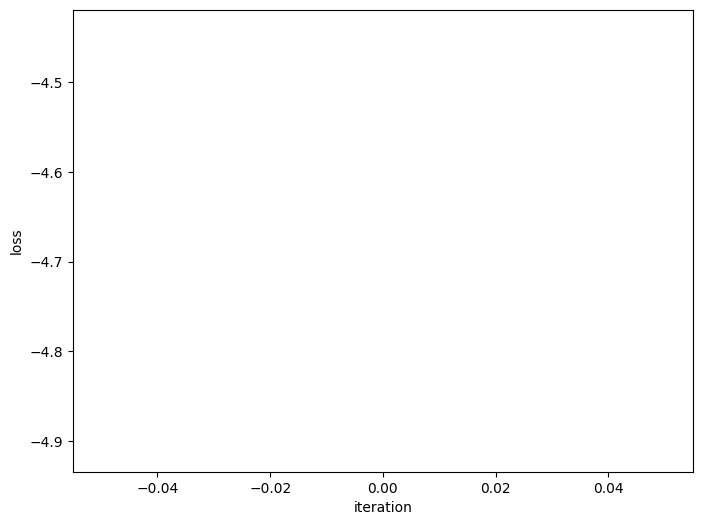

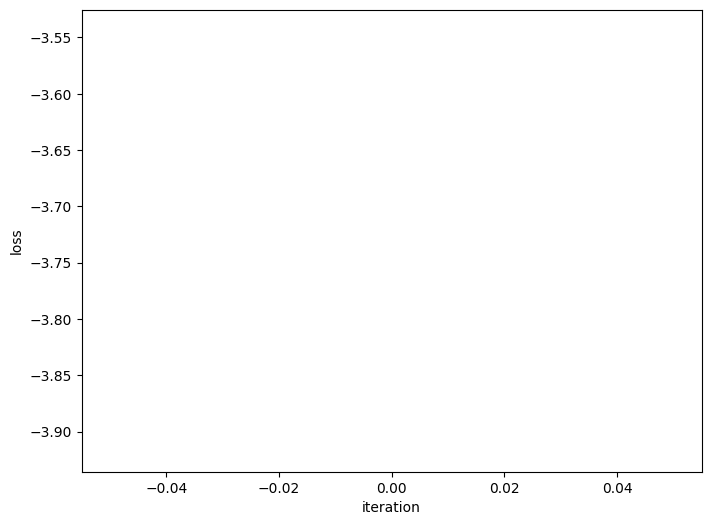

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -718.62008  validloss -689.79146±0.00000  bestvalidloss -689.79146  last_update 0
train: iter 1  trainloss -736.92072  validloss -689.44224±0.00000  bestvalidloss -689.79146  last_update 1
train: iter 2  trainloss -720.77066  validloss -672.10043±0.00000  bestvalidloss -689.79146  last_update 2
train: iter 3  trainloss -734.96879  validloss -713.17421±0.00000  bestvalidloss -713.17421  last_update 0
train: iter 4  trainloss -728.28035  validloss -673.78029±0.00000  bestvalidloss -713.17421  last_update 1
train: iter 5  trainloss -726.69346  validloss -685.12991±0.00000  bestvalidloss -713.17421  last_update 2
train: iter 6  trainloss -726.48080  validloss -665.86865±0.00000  bestvalidloss -713.17421  last_update 3
train: iter 7  trainloss -743.35965  validloss -693.34635±0.00000  bestvalidloss -713.17421  last_update 4
train: iter 8  trainloss -738.26540  validloss -681.67471±0.00000  bestvalidloss -713.17421  last_u

train: iter 76  trainloss -748.16005  validloss -721.44847±0.00000  bestvalidloss -721.45461  last_update 1
train: iter 77  trainloss -742.69801  validloss -693.72382±0.00000  bestvalidloss -721.45461  last_update 2
train: iter 78  trainloss -732.41683  validloss -657.78325±0.00000  bestvalidloss -721.45461  last_update 3
train: iter 79  trainloss -739.78239  validloss -695.32623±0.00000  bestvalidloss -721.45461  last_update 4
train: iter 80  trainloss -743.74370  validloss -713.23855±0.00000  bestvalidloss -721.45461  last_update 5
train: iter 81  trainloss -737.20119  validloss -706.08644±0.00000  bestvalidloss -721.45461  last_update 6
train: iter 82  trainloss -751.97575  validloss -683.78493±0.00000  bestvalidloss -721.45461  last_update 7
train: iter 83  trainloss -741.47124  validloss -692.33889±0.00000  bestvalidloss -721.45461  last_update 8
train: iter 84  trainloss -736.26464  validloss -632.95991±0.00000  bestvalidloss -721.45461  last_update 9
train: iter 85  trainloss -7

train: iter 152  trainloss -767.35527  validloss -692.86121±0.00000  bestvalidloss -742.38696  last_update 16
train: iter 153  trainloss -729.28995  validloss -708.11504±0.00000  bestvalidloss -742.38696  last_update 17
train: iter 154  trainloss -717.89035  validloss -569.08611±0.00000  bestvalidloss -742.38696  last_update 18
train: iter 155  trainloss -763.89530  validloss -710.82458±0.00000  bestvalidloss -742.38696  last_update 19
train: iter 156  trainloss -758.14993  validloss -712.09584±0.00000  bestvalidloss -742.38696  last_update 20
train: iter 157  trainloss -763.42518  validloss -712.39664±0.00000  bestvalidloss -742.38696  last_update 21
train: iter 158  trainloss -769.83991  validloss -691.23768±0.00000  bestvalidloss -742.38696  last_update 22
train: iter 159  trainloss -766.27971  validloss -709.20445±0.00000  bestvalidloss -742.38696  last_update 23
train: iter 160  trainloss -746.42780  validloss -707.48432±0.00000  bestvalidloss -742.38696  last_update 24
train: ite

train: iter 227  trainloss -751.02329  validloss -726.70855±0.00000  bestvalidloss -742.38696  last_update 91
train: iter 228  trainloss -755.11724  validloss -655.70379±0.00000  bestvalidloss -742.38696  last_update 92
train: iter 229  trainloss -777.49621  validloss -718.05050±0.00000  bestvalidloss -742.38696  last_update 93
train: iter 230  trainloss -777.21138  validloss -680.20492±0.00000  bestvalidloss -742.38696  last_update 94
train: iter 231  trainloss -775.60472  validloss -693.74667±0.00000  bestvalidloss -742.38696  last_update 95
train: iter 232  trainloss -737.63842  validloss -713.20400±0.00000  bestvalidloss -742.38696  last_update 96
train: iter 233  trainloss -772.94940  validloss -704.73236±0.00000  bestvalidloss -742.38696  last_update 97
train: iter 234  trainloss -773.16593  validloss -722.65279±0.00000  bestvalidloss -742.38696  last_update 98
train: iter 235  trainloss -761.39926  validloss -713.29642±0.00000  bestvalidloss -742.38696  last_update 99
train: ite

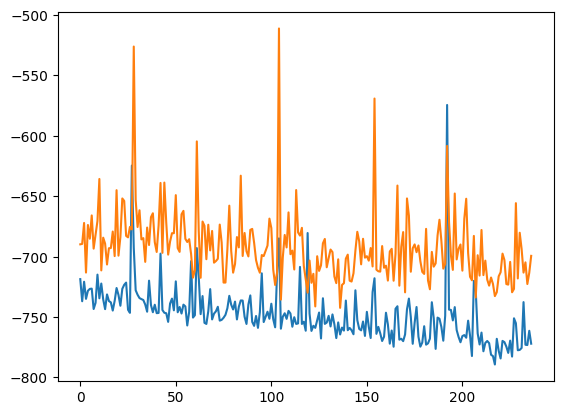

alpha 0.1 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-07-27 20:58:31.330503


# Iter2

In [17]:
policy_evaluation_iter=1

In [18]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6
predict diverge [-7.68144557  3.02375378 -8.23570356 34.5096297 ] [ 0.1652619  -3.33319647  1.10670499  8.95760208] [127.00345  20.62193 193.51599  33.23519] [63.501724 10.310965 96.757996 16.617596] sim_timestep 94

 7
predict diverge [ 0.45725672  4.12380681 -7.21784704 37.32030224] [ 0.21365744 -2.54746503  1.18283113 11.49911728] [127.00345  20.62193 193.51599  33.23519] [63.501724 10.310965 96.757996 16.617596] sim_timestep 99

 8
predict diverge [ -1.49447951  20.36041322 -13.03242294  52.73723241] [ 0.21646351 11.74336302  1.54954851 21.30594707] [127.00345  20.62193 193.51599  33.23519] [63.501724 10.310965 96.757996 16.617596] sim_timestep 104

 9
predict diverge [12.697111   -2.04512974 15.6743646  38.28626127] [  0.32453398 -10.74874725   1.35773922   6.02377387] [127.00345  20.62193 193.51599  33.23519] [63.501724 10.310965 96.757996 16.617596] sim_timestep 117

 10

 11

 12

 13

 14

 15
predict diverge [-2.72592912  2.30073747 -7.46658515 36.

In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.55226  validloss 4.23470±0.00000  bestvalidloss 4.23470  last_update 0
train: iter 1  trainloss 0.87744  validloss 0.96667±0.00000  bestvalidloss 0.96667  last_update 0
train: iter 2  trainloss 0.70254  validloss 0.75155±0.00000  bestvalidloss 0.75155  last_update 0
train: iter 3  trainloss 0.65173  validloss 0.67548±0.00000  bestvalidloss 0.67548  last_update 0
train: iter 4  trainloss 0.62230  validloss 0.65359±0.00000  bestvalidloss 0.65359  last_update 0
train: iter 5  trainloss 0.60656  validloss 0.62511±0.00000  bestvalidloss 0.62511  last_update 0
train: iter 6  trainloss 0.58866  validloss 0.61618±0.00000  bestvalidloss 0.61618  last_update 0
train: iter 7  trainloss 0.57469  validloss 0.60115±0.00000  bestvalidloss 0.60115  last_update 0
train: iter 8  trainloss 0.56602  validloss 0.60680±0.00000  bestvalidloss 0.60115  last_update 1
train: iter 9  trainloss 0.55932  validloss 0.59381±0.00000  bestvalidloss 0.59381  last_update 0
train: iter 10  trai

train: iter 84  trainloss 0.41847  validloss 0.54235±0.00000  bestvalidloss 0.52017  last_update 6
train: iter 85  trainloss 0.41805  validloss 0.52426±0.00000  bestvalidloss 0.52017  last_update 7
train: iter 86  trainloss 0.41803  validloss 0.53684±0.00000  bestvalidloss 0.52017  last_update 8
train: iter 87  trainloss 0.41724  validloss 0.53387±0.00000  bestvalidloss 0.52017  last_update 9
train: iter 88  trainloss 0.41628  validloss 0.52910±0.00000  bestvalidloss 0.52017  last_update 10
train: iter 89  trainloss 0.41573  validloss 0.53941±0.00000  bestvalidloss 0.52017  last_update 11
train: iter 90  trainloss 0.41379  validloss 0.54279±0.00000  bestvalidloss 0.52017  last_update 12
train: iter 91  trainloss 0.41379  validloss 0.56070±0.00000  bestvalidloss 0.52017  last_update 13
train: iter 92  trainloss 0.41659  validloss 0.55324±0.00000  bestvalidloss 0.52017  last_update 14
train: iter 93  trainloss 0.41405  validloss 0.55280±0.00000  bestvalidloss 0.52017  last_update 15
trai

train: iter 166  trainloss 0.39059  validloss 0.53255±0.00000  bestvalidloss 0.51943  last_update 6
train: iter 167  trainloss 0.39069  validloss 0.52535±0.00000  bestvalidloss 0.51943  last_update 7
train: iter 168  trainloss 0.39457  validloss 0.54346±0.00000  bestvalidloss 0.51943  last_update 8
train: iter 169  trainloss 0.38869  validloss 0.53587±0.00000  bestvalidloss 0.51943  last_update 9
train: iter 170  trainloss 0.38883  validloss 0.55612±0.00000  bestvalidloss 0.51943  last_update 10
train: iter 171  trainloss 0.38523  validloss 0.52517±0.00000  bestvalidloss 0.51943  last_update 11
train: iter 172  trainloss 0.38684  validloss 0.54863±0.00000  bestvalidloss 0.51943  last_update 12
train: iter 173  trainloss 0.38906  validloss 0.55485±0.00000  bestvalidloss 0.51943  last_update 13
train: iter 174  trainloss 0.38783  validloss 0.51971±0.00000  bestvalidloss 0.51943  last_update 14
train: iter 175  trainloss 0.38775  validloss 0.51884±0.00000  bestvalidloss 0.51884  last_upda

train: iter 248  trainloss 0.37338  validloss 0.53852±0.00000  bestvalidloss 0.51650  last_update 39
train: iter 249  trainloss 0.37326  validloss 0.54232±0.00000  bestvalidloss 0.51650  last_update 40
train: iter 250  trainloss 0.37598  validloss 0.52797±0.00000  bestvalidloss 0.51650  last_update 41
train: iter 251  trainloss 0.37131  validloss 0.56283±0.00000  bestvalidloss 0.51650  last_update 42
train: iter 252  trainloss 0.37647  validloss 0.54295±0.00000  bestvalidloss 0.51650  last_update 43
train: iter 253  trainloss 0.37899  validloss 0.55096±0.00000  bestvalidloss 0.51650  last_update 44
train: iter 254  trainloss 0.37270  validloss 0.52714±0.00000  bestvalidloss 0.51650  last_update 45
train: iter 255  trainloss 0.37204  validloss 0.54689±0.00000  bestvalidloss 0.51650  last_update 46
train: iter 256  trainloss 0.37308  validloss 0.56318±0.00000  bestvalidloss 0.51650  last_update 47
train: iter 257  trainloss 0.36856  validloss 0.52762±0.00000  bestvalidloss 0.51650  last_

train_loss:  -5.050361482805014
valid_loss:  -5.481207765865326
weight_alpha 1.0 h_min_tilde -11.610874 ell_tilde -5.136530739417077 kappa_tilde 0.0003930086719419237
train_loss:  -4.298642802524567
valid_loss:  -3.874972932052613
weight_alpha 0.1 h_min_tilde -11.610874 ell_tilde -4.213908828430176 kappa_tilde 0.00036768270994125355


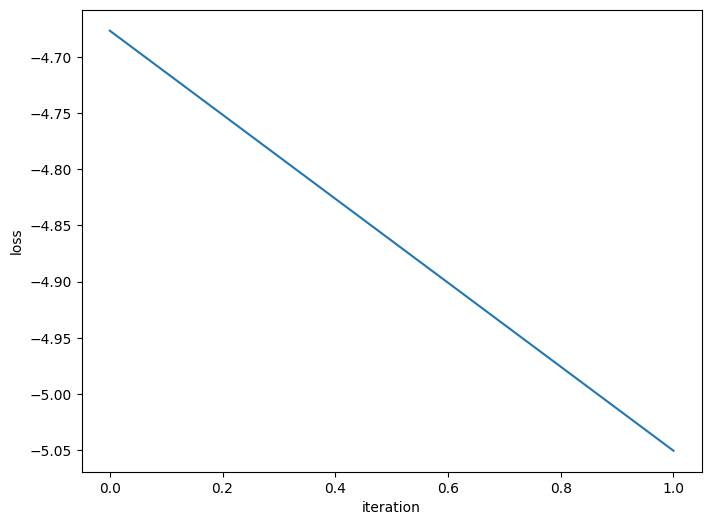

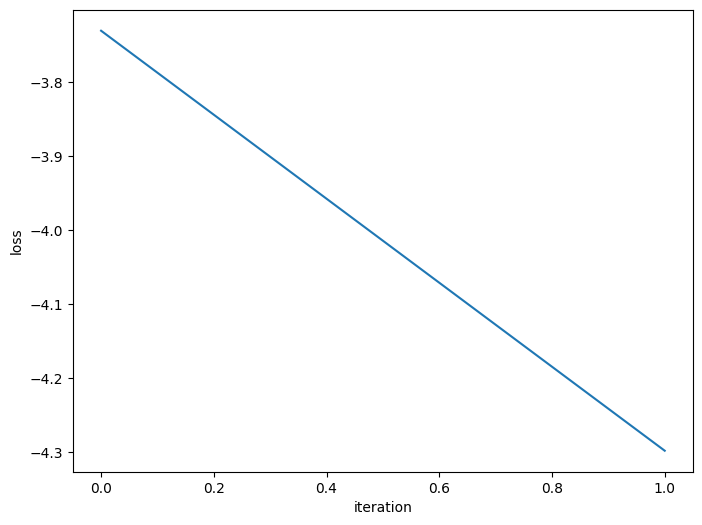

In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -828.44765  validloss -777.27288±0.00000  bestvalidloss -777.27288  last_update 0
train: iter 1  trainloss -832.19441  validloss -698.92096±0.00000  bestvalidloss -777.27288  last_update 1
train: iter 2  trainloss -807.08366  validloss -746.11714±0.00000  bestvalidloss -777.27288  last_update 2
train: iter 3  trainloss -841.65894  validloss -766.33847±0.00000  bestvalidloss -777.27288  last_update 3
train: iter 4  trainloss -837.61087  validloss -736.33756±0.00000  bestvalidloss -777.27288  last_update 4
train: iter 5  trainloss -788.10570  validloss -769.36703±0.00000  bestvalidloss -777.27288  last_update 5
train: iter 6  trainloss -847.60791  validloss -744.20836±0.00000  bestvalidloss -777.27288  last_update 6
train: iter 7  trainloss -856.91055  validloss -778.83506±0.00000  bestvalidloss -778.83506  last_update 0
train: iter 8  trainloss -831.47701  validloss -761.96746±0.00000  bestvalidloss -778.83506  last_u

train: iter 76  trainloss -781.95588  validloss -769.92212±0.00000  bestvalidloss -793.94795  last_update 31
train: iter 77  trainloss -844.98958  validloss -768.15956±0.00000  bestvalidloss -793.94795  last_update 32
train: iter 78  trainloss -841.09677  validloss -739.55787±0.00000  bestvalidloss -793.94795  last_update 33
train: iter 79  trainloss -852.65688  validloss -773.51373±0.00000  bestvalidloss -793.94795  last_update 34
train: iter 80  trainloss -860.15743  validloss -776.64229±0.00000  bestvalidloss -793.94795  last_update 35
train: iter 81  trainloss -859.47358  validloss -742.95521±0.00000  bestvalidloss -793.94795  last_update 36
train: iter 82  trainloss -805.29078  validloss -754.58607±0.00000  bestvalidloss -793.94795  last_update 37
train: iter 83  trainloss -854.52406  validloss -760.85904±0.00000  bestvalidloss -793.94795  last_update 38
train: iter 84  trainloss -866.00940  validloss -800.53805±0.00000  bestvalidloss -800.53805  last_update 0
train: iter 85  trai

train: iter 151  trainloss -875.34394  validloss -781.93932±0.00000  bestvalidloss -800.53805  last_update 67
train: iter 152  trainloss -866.98311  validloss -787.35005±0.00000  bestvalidloss -800.53805  last_update 68
train: iter 153  trainloss -825.99838  validloss -736.10073±0.00000  bestvalidloss -800.53805  last_update 69
train: iter 154  trainloss -821.58834  validloss -612.98312±0.00000  bestvalidloss -800.53805  last_update 70
train: iter 155  trainloss -860.69892  validloss -762.32339±0.00000  bestvalidloss -800.53805  last_update 71
train: iter 156  trainloss -836.84725  validloss -770.62045±0.00000  bestvalidloss -800.53805  last_update 72
train: iter 157  trainloss -873.55111  validloss -733.26537±0.00000  bestvalidloss -800.53805  last_update 73
train: iter 158  trainloss -859.90672  validloss -775.64646±0.00000  bestvalidloss -800.53805  last_update 74
train: iter 159  trainloss -844.05356  validloss -774.99800±0.00000  bestvalidloss -800.53805  last_update 75
train: ite

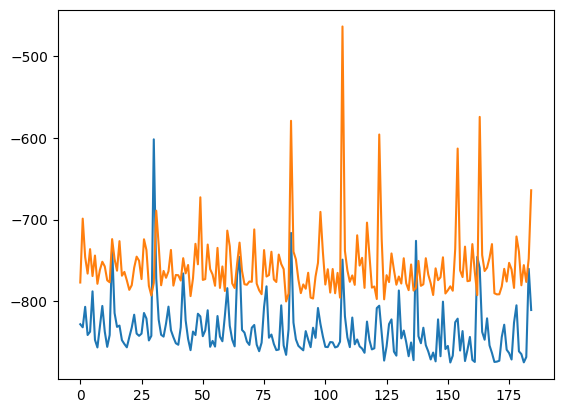

alpha 0.1 default_lr 0.0005


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [23]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [24]:
print(datetime.datetime.now())

2023-07-27 21:17:59.303225


In [25]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [26]:
policy_evaluation_iter=2

In [27]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [28]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.57114  validloss 0.82318±0.00000  bestvalidloss 0.82318  last_update 0
train: iter 1  trainloss 0.52694  validloss 0.46585±0.00000  bestvalidloss 0.46585  last_update 0
train: iter 2  trainloss 0.50864  validloss 0.45908±0.00000  bestvalidloss 0.45908  last_update 0
train: iter 3  trainloss 0.49758  validloss 0.47482±0.00000  bestvalidloss 0.45908  last_update 1
train: iter 4  trainloss 0.48440  validloss 0.47778±0.00000  bestvalidloss 0.45908  last_update 2
train: iter 5  trainloss 0.47636  validloss 0.45862±0.00000  bestvalidloss 0.45862  last_update 0
train: iter 6  trainloss 0.46721  validloss 0.44320±0.00000  bestvalidloss 0.44320  last_update 0
train: iter 7  trainloss 0.46435  validloss 0.45034±0.00000  bestvalidloss 0.44320  last_update 1
train: iter 8  trainloss 0.45606  validloss 0.45358±0.00000  bestvalidloss 0.44320  last_update 2
train: iter 9  trainloss 0.45692  validloss 0.43638±0.00000  bestvalidloss 0.43638  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.40671  validloss 0.45756±0.00000  bestvalidloss 0.41561  last_update 63
train: iter 84  trainloss 0.39868  validloss 0.44643±0.00000  bestvalidloss 0.41561  last_update 64
train: iter 85  trainloss 0.40270  validloss 0.48070±0.00000  bestvalidloss 0.41561  last_update 65
train: iter 86  trainloss 0.39687  validloss 0.44573±0.00000  bestvalidloss 0.41561  last_update 66
train: iter 87  trainloss 0.40445  validloss 0.50455±0.00000  bestvalidloss 0.41561  last_update 67
train: iter 88  trainloss 0.39482  validloss 0.44076±0.00000  bestvalidloss 0.41561  last_update 68
train: iter 89  trainloss 0.39740  validloss 0.46087±0.00000  bestvalidloss 0.41561  last_update 69
train: iter 90  trainloss 0.39860  validloss 0.48712±0.00000  bestvalidloss 0.41561  last_update 70
train: iter 91  trainloss 0.40034  validloss 0.45877±0.00000  bestvalidloss 0.41561  last_update 71
train: iter 92  trainloss 0.39924  validloss 0.44286±0.00000  bestvalidloss 0.41561  last_update 72


train_loss:  -4.393163301169872
valid_loss:  -2.900478787994385
weight_alpha 1.0 h_min_tilde -11.517157 ell_tilde -4.094626398534774 kappa_tilde 0.00036704897302627904
train_loss:  -4.523690872049331
valid_loss:  -3.7327451487541206
weight_alpha 0.1 h_min_tilde -11.517157 ell_tilde -4.3655017273902885 kappa_tilde 0.0003739355246599307


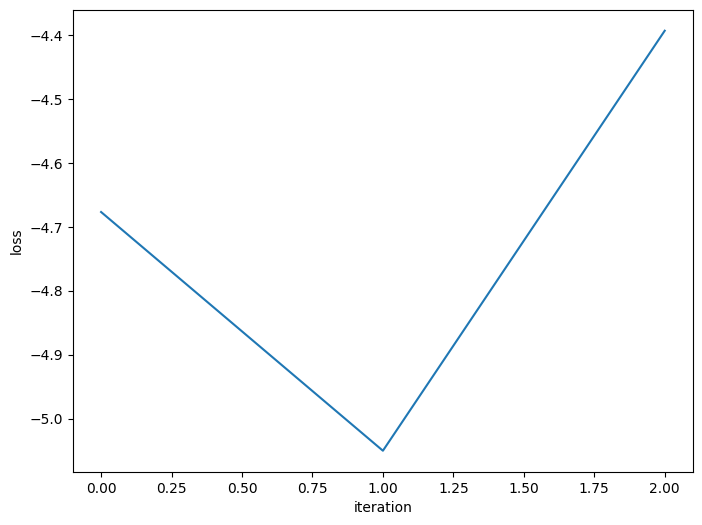

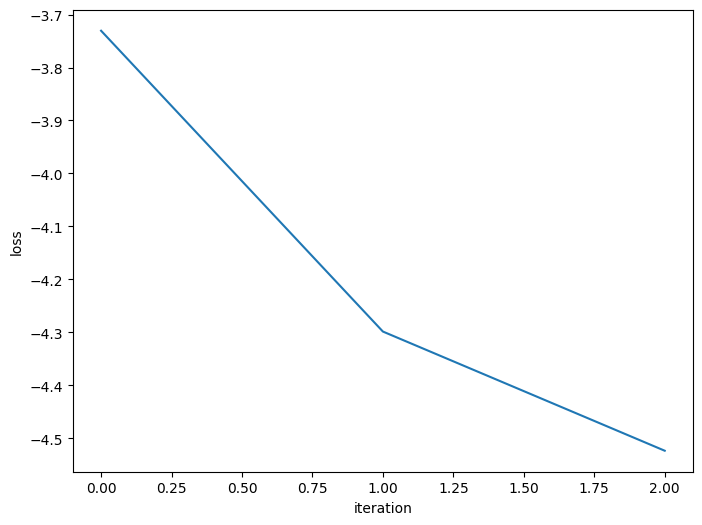

In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")


In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -893.72813  validloss -742.74950±0.00000  bestvalidloss -742.74950  last_update 0
train: iter 1  trainloss -908.03749  validloss -740.58636±0.00000  bestvalidloss -742.74950  last_update 1
train: iter 2  trainloss -897.95228  validloss -750.73869±0.00000  bestvalidloss -750.73869  last_update 0
train: iter 3  trainloss -897.13858  validloss -757.78203±0.00000  bestvalidloss -757.78203  last_update 0
train: iter 4  trainloss -908.58926  validloss -680.33403±0.00000  bestvalidloss -757.78203  last_update 1
train: iter 5  trainloss -881.85246  validloss -716.01225±0.00000  bestvalidloss -757.78203  last_update 2
train: iter 6  trainloss -891.33598  validloss -754.38024±0.00000  bestvalidloss -757.78203  last_update 3
train: iter 7  trainloss -917.48001  validloss -792.83411±0.00000  bestvalidloss -792.83411  last_update 0
train: iter 8  trainloss -905.90160  validloss -750.58911±0.00000  bestvalidloss -792.83411  last_u

train: iter 76  trainloss -796.17287  validloss -559.12651±0.00000  bestvalidloss -813.03202  last_update 10
train: iter 77  trainloss -888.54564  validloss -718.48746±0.00000  bestvalidloss -813.03202  last_update 11
train: iter 78  trainloss -919.68035  validloss -738.88081±0.00000  bestvalidloss -813.03202  last_update 12
train: iter 79  trainloss -922.23620  validloss -761.04836±0.00000  bestvalidloss -813.03202  last_update 13
train: iter 80  trainloss -931.59604  validloss -699.80733±0.00000  bestvalidloss -813.03202  last_update 14
train: iter 81  trainloss -933.51438  validloss -771.48284±0.00000  bestvalidloss -813.03202  last_update 15
train: iter 82  trainloss -907.28674  validloss -741.07003±0.00000  bestvalidloss -813.03202  last_update 16
train: iter 83  trainloss -920.42664  validloss -745.03117±0.00000  bestvalidloss -813.03202  last_update 17
train: iter 84  trainloss -935.84891  validloss -771.53166±0.00000  bestvalidloss -813.03202  last_update 18
train: iter 85  tra

train: iter 152  trainloss -973.05779  validloss -819.92633±0.00000  bestvalidloss -834.20141  last_update 19
train: iter 153  trainloss -959.99450  validloss -760.77249±0.00000  bestvalidloss -834.20141  last_update 20
train: iter 154  trainloss -970.74602  validloss -823.76281±0.00000  bestvalidloss -834.20141  last_update 21
train: iter 155  trainloss -931.05354  validloss -758.60420±0.00000  bestvalidloss -834.20141  last_update 22
train: iter 156  trainloss -948.92615  validloss -782.10255±0.00000  bestvalidloss -834.20141  last_update 23
train: iter 157  trainloss -964.43210  validloss -790.74722±0.00000  bestvalidloss -834.20141  last_update 24
train: iter 158  trainloss -967.35904  validloss -771.42368±0.00000  bestvalidloss -834.20141  last_update 25
train: iter 159  trainloss -934.61991  validloss -767.37653±0.00000  bestvalidloss -834.20141  last_update 26
train: iter 160  trainloss -976.22638  validloss -820.87732±0.00000  bestvalidloss -834.20141  last_update 27
train: ite

train: iter 227  trainloss -973.86521  validloss -777.47459±0.00000  bestvalidloss -855.81036  last_update 52
train: iter 228  trainloss -956.59359  validloss -695.54550±0.00000  bestvalidloss -855.81036  last_update 53
train: iter 229  trainloss -969.04405  validloss -812.00468±0.00000  bestvalidloss -855.81036  last_update 54
train: iter 230  trainloss -960.50742  validloss -783.07361±0.00000  bestvalidloss -855.81036  last_update 55
train: iter 231  trainloss -991.01112  validloss -823.46527±0.00000  bestvalidloss -855.81036  last_update 56
train: iter 232  trainloss -999.87548  validloss -817.68877±0.00000  bestvalidloss -855.81036  last_update 57
train: iter 233  trainloss -997.26702  validloss -806.07884±0.00000  bestvalidloss -855.81036  last_update 58
train: iter 234  trainloss -980.59616  validloss -825.42251±0.00000  bestvalidloss -855.81036  last_update 59
train: iter 235  trainloss -961.35464  validloss -817.60643±0.00000  bestvalidloss -855.81036  last_update 60
train: ite

train: iter 302  trainloss -1014.89444  validloss -815.45966±0.00000  bestvalidloss -875.78378  last_update 1
train: iter 303  trainloss -1002.62959  validloss -791.15778±0.00000  bestvalidloss -875.78378  last_update 2
train: iter 304  trainloss -986.64163  validloss -812.77201±0.00000  bestvalidloss -875.78378  last_update 3
train: iter 305  trainloss -1019.95673  validloss -881.93595±0.00000  bestvalidloss -881.93595  last_update 0
train: iter 306  trainloss -1036.11376  validloss -891.63443±0.00000  bestvalidloss -891.63443  last_update 0
train: iter 307  trainloss -876.47899  validloss -794.30920±0.00000  bestvalidloss -891.63443  last_update 1
train: iter 308  trainloss -997.42600  validloss -824.18200±0.00000  bestvalidloss -891.63443  last_update 2
train: iter 309  trainloss -1012.53700  validloss -804.83955±0.00000  bestvalidloss -891.63443  last_update 3
train: iter 310  trainloss -991.32751  validloss -858.95378±0.00000  bestvalidloss -891.63443  last_update 4
train: iter 31

train: iter 377  trainloss -1021.79808  validloss -828.82057±0.00000  bestvalidloss -891.63443  last_update 71
train: iter 378  trainloss -973.92378  validloss -832.49853±0.00000  bestvalidloss -891.63443  last_update 72
train: iter 379  trainloss -1014.70303  validloss -841.70881±0.00000  bestvalidloss -891.63443  last_update 73
train: iter 380  trainloss -1002.13644  validloss -898.87746±0.00000  bestvalidloss -898.87746  last_update 0
train: iter 381  trainloss -974.71853  validloss -818.44456±0.00000  bestvalidloss -898.87746  last_update 1
train: iter 382  trainloss -1032.40044  validloss -872.25387±0.00000  bestvalidloss -898.87746  last_update 2
train: iter 383  trainloss -1019.61270  validloss -858.58198±0.00000  bestvalidloss -898.87746  last_update 3
train: iter 384  trainloss -1002.01863  validloss -856.54996±0.00000  bestvalidloss -898.87746  last_update 4
train: iter 385  trainloss -1024.81541  validloss -811.07218±0.00000  bestvalidloss -898.87746  last_update 5
train: it

train: iter 452  trainloss -995.82392  validloss -775.88644±0.00000  bestvalidloss -905.72876  last_update 43
train: iter 453  trainloss -1038.90500  validloss -888.72062±0.00000  bestvalidloss -905.72876  last_update 44
train: iter 454  trainloss -1042.20180  validloss -843.31578±0.00000  bestvalidloss -905.72876  last_update 45
train: iter 455  trainloss -1050.89304  validloss -872.31759±0.00000  bestvalidloss -905.72876  last_update 46
train: iter 456  trainloss -1046.13906  validloss -888.47097±0.00000  bestvalidloss -905.72876  last_update 47
train: iter 457  trainloss -1040.46876  validloss -874.18304±0.00000  bestvalidloss -905.72876  last_update 48
train: iter 458  trainloss -1053.10350  validloss -851.72355±0.00000  bestvalidloss -905.72876  last_update 49
train: iter 459  trainloss -881.60761  validloss -853.97178±0.00000  bestvalidloss -905.72876  last_update 50
train: iter 460  trainloss -981.56996  validloss -827.01919±0.00000  bestvalidloss -905.72876  last_update 51
trai

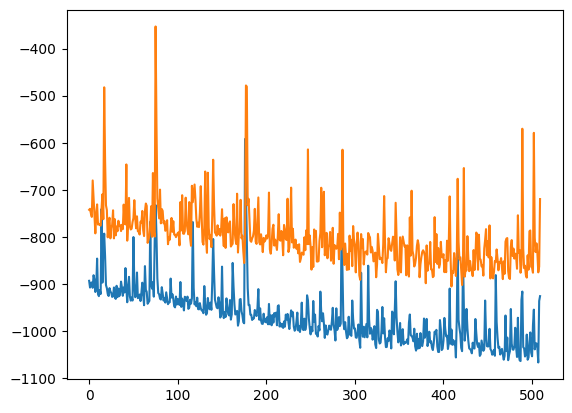

alpha 0.1 default_lr 0.0005


In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [32]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [33]:
print(datetime.datetime.now())

2023-07-27 21:37:46.866775


# Iter 4

In [34]:
policy_evaluation_iter=3

In [35]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55
predict diverge [  1.76322839  10.62897665 -31.84573539  34.51902515] [ 0.43403788 -0.29483629  0.59391919  7.52296726] [127.00345  20.62193 193.51599  33.23519] [63.501724 10.310965 96.757996 16.617596] sim_timestep 136

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82
predict diverge [ 24.15942867   0.6789883  -24.08109256  48.0678767 ] [-4.62220644e-03  3.16437691e+00  7.09244921e-01  1.90648983e+01] [127.00345  20.62193 193.51599  33.23519] [63.501724 10.310965 96.757996 16.617596] sim_timestep 151

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92
predict diverge [ -3.44782001 -12.07551626 -20.65823348 110.15623233] [  0.22318985 -16

In [36]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.69014  validloss 0.82573±0.00000  bestvalidloss 0.82573  last_update 0
train: iter 1  trainloss 0.61798  validloss 0.62677±0.00000  bestvalidloss 0.62677  last_update 0
train: iter 2  trainloss 0.59262  validloss 0.61724±0.00000  bestvalidloss 0.61724  last_update 0
train: iter 3  trainloss 0.57844  validloss 0.60291±0.00000  bestvalidloss 0.60291  last_update 0
train: iter 4  trainloss 0.55661  validloss 0.59032±0.00000  bestvalidloss 0.59032  last_update 0
train: iter 5  trainloss 0.54432  validloss 0.57103±0.00000  bestvalidloss 0.57103  last_update 0
train: iter 6  trainloss 0.53764  validloss 0.56156±0.00000  bestvalidloss 0.56156  last_update 0
train: iter 7  trainloss 0.52805  validloss 0.56011±0.00000  bestvalidloss 0.56011  last_update 0
train: iter 8  trainloss 0.52763  validloss 0.57374±0.00000  bestvalidloss 0.56011  last_update 1
train: iter 9  trainloss 0.52068  validloss 0.54859±0.00000  bestvalidloss 0.54859  last_update 0
train: iter 10  trai

train: iter 84  trainloss 0.42761  validloss 0.50456±0.00000  bestvalidloss 0.48308  last_update 10
train: iter 85  trainloss 0.43261  validloss 0.51160±0.00000  bestvalidloss 0.48308  last_update 11
train: iter 86  trainloss 0.42860  validloss 0.48983±0.00000  bestvalidloss 0.48308  last_update 12
train: iter 87  trainloss 0.43165  validloss 0.51029±0.00000  bestvalidloss 0.48308  last_update 13
train: iter 88  trainloss 0.43639  validloss 0.50990±0.00000  bestvalidloss 0.48308  last_update 14
train: iter 89  trainloss 0.42575  validloss 0.50336±0.00000  bestvalidloss 0.48308  last_update 15
train: iter 90  trainloss 0.42573  validloss 0.49735±0.00000  bestvalidloss 0.48308  last_update 16
train: iter 91  trainloss 0.43052  validloss 0.55937±0.00000  bestvalidloss 0.48308  last_update 17
train: iter 92  trainloss 0.42291  validloss 0.50303±0.00000  bestvalidloss 0.48308  last_update 18
train: iter 93  trainloss 0.42555  validloss 0.49420±0.00000  bestvalidloss 0.48308  last_update 19


train: iter 166  trainloss 0.40543  validloss 0.50289±0.00000  bestvalidloss 0.48228  last_update 46
train: iter 167  trainloss 0.40892  validloss 0.51510±0.00000  bestvalidloss 0.48228  last_update 47
train: iter 168  trainloss 0.40574  validloss 0.50813±0.00000  bestvalidloss 0.48228  last_update 48
train: iter 169  trainloss 0.40765  validloss 0.53154±0.00000  bestvalidloss 0.48228  last_update 49
train: iter 170  trainloss 0.40792  validloss 0.50478±0.00000  bestvalidloss 0.48228  last_update 50
train: iter 171  trainloss 0.40909  validloss 0.50067±0.00000  bestvalidloss 0.48228  last_update 51
train: iter 172  trainloss 0.40592  validloss 0.54918±0.00000  bestvalidloss 0.48228  last_update 52
train: iter 173  trainloss 0.40956  validloss 0.52274±0.00000  bestvalidloss 0.48228  last_update 53
train: iter 174  trainloss 0.40897  validloss 0.50059±0.00000  bestvalidloss 0.48228  last_update 54
train: iter 175  trainloss 0.40420  validloss 0.50989±0.00000  bestvalidloss 0.48228  last_

train_loss:  -5.105660463696717
valid_loss:  -5.858416026163101
weight_alpha 1.0 h_min_tilde -11.41184 ell_tilde -5.256211576189994 kappa_tilde 0.0004030545111752145
train_loss:  -4.5205438061475745
valid_loss:  -4.03223239440918
weight_alpha 0.1 h_min_tilde -11.41184 ell_tilde -4.422881523799896 kappa_tilde 0.00037826290737109577


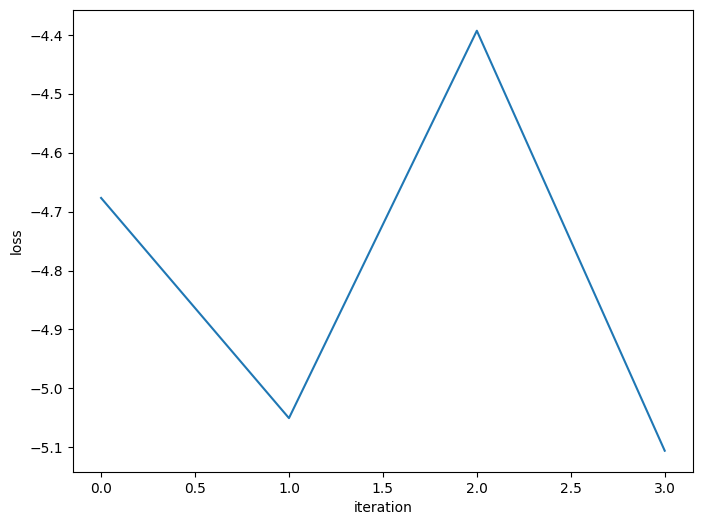

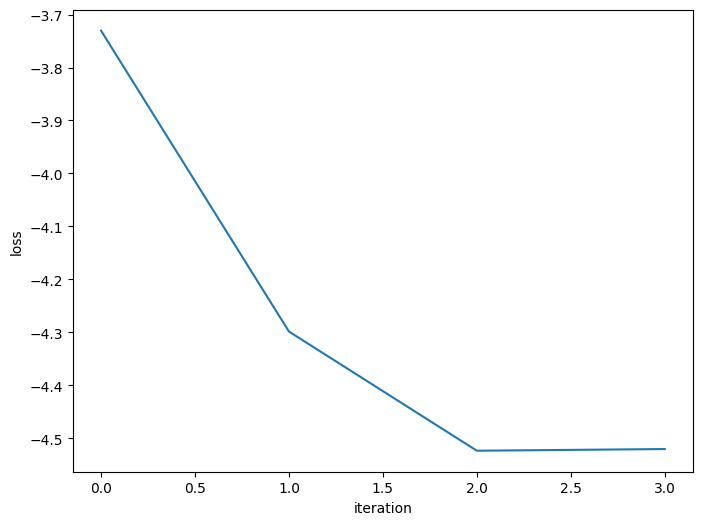

In [37]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -896.99150  validloss -809.22109±0.00000  bestvalidloss -809.22109  last_update 0
train: iter 1  trainloss -918.90834  validloss -814.19303±0.00000  bestvalidloss -814.19303  last_update 0
train: iter 2  trainloss -893.28208  validloss -850.03272±0.00000  bestvalidloss -850.03272  last_update 0
train: iter 3  trainloss -923.46731  validloss -833.02331±0.00000  bestvalidloss -850.03272  last_update 1
train: iter 4  trainloss -943.11750  validloss -830.23913±0.00000  bestvalidloss -850.03272  last_update 2
train: iter 5  trainloss -898.93201  validloss -868.43903±0.00000  bestvalidloss -868.43903  last_update 0
train: iter 6  trainloss -926.27026  validloss -834.26647±0.00000  bestvalidloss -868.43903  last_update 1
train: iter 7  trainloss -907.62141  validloss -867.80418±0.00000  bestvalidloss -868.43903  last_update 2
train: iter 8  trainloss -915.94730  validloss -845.76428±0.00000  bestvalidloss -868.43903  last_u

train: iter 76  trainloss -928.18273  validloss -870.49171±0.00000  bestvalidloss -887.34045  last_update 27
train: iter 77  trainloss -942.50952  validloss -879.06124±0.00000  bestvalidloss -887.34045  last_update 28
train: iter 78  trainloss -930.44857  validloss -868.11594±0.00000  bestvalidloss -887.34045  last_update 29
train: iter 79  trainloss -700.80791  validloss -858.43178±0.00000  bestvalidloss -887.34045  last_update 30
train: iter 80  trainloss -887.18826  validloss -764.78230±0.00000  bestvalidloss -887.34045  last_update 31
train: iter 81  trainloss -919.54763  validloss -859.06344±0.00000  bestvalidloss -887.34045  last_update 32
train: iter 82  trainloss -926.67899  validloss -811.45681±0.00000  bestvalidloss -887.34045  last_update 33
train: iter 83  trainloss -930.82740  validloss -824.76532±0.00000  bestvalidloss -887.34045  last_update 34
train: iter 84  trainloss -944.34507  validloss -864.35883±0.00000  bestvalidloss -887.34045  last_update 35
train: iter 85  tra

train: iter 151  trainloss -934.79851  validloss -862.17134±0.00000  bestvalidloss -891.76180  last_update 44
train: iter 152  trainloss -946.81293  validloss -841.50901±0.00000  bestvalidloss -891.76180  last_update 45
train: iter 153  trainloss -928.00966  validloss -852.83504±0.00000  bestvalidloss -891.76180  last_update 46
train: iter 154  trainloss -911.90597  validloss -785.65459±0.00000  bestvalidloss -891.76180  last_update 47
train: iter 155  trainloss -916.97806  validloss -798.31443±0.00000  bestvalidloss -891.76180  last_update 48
train: iter 156  trainloss -949.05171  validloss -830.53732±0.00000  bestvalidloss -891.76180  last_update 49
train: iter 157  trainloss -871.18523  validloss -834.93017±0.00000  bestvalidloss -891.76180  last_update 50
train: iter 158  trainloss -911.71000  validloss -831.46461±0.00000  bestvalidloss -891.76180  last_update 51
train: iter 159  trainloss -933.88831  validloss -834.18229±0.00000  bestvalidloss -891.76180  last_update 52
train: ite

train: iter 226  trainloss -938.36678  validloss -834.48617±0.00000  bestvalidloss -891.99199  last_update 32
train: iter 227  trainloss -799.36762  validloss -815.20081±0.00000  bestvalidloss -891.99199  last_update 33
train: iter 228  trainloss -814.58516  validloss -468.47463±0.00000  bestvalidloss -891.99199  last_update 34
train: iter 229  trainloss -926.79794  validloss -829.96789±0.00000  bestvalidloss -891.99199  last_update 35
train: iter 230  trainloss -909.00431  validloss -846.97053±0.00000  bestvalidloss -891.99199  last_update 36
train: iter 231  trainloss -935.87033  validloss -874.33018±0.00000  bestvalidloss -891.99199  last_update 37
train: iter 232  trainloss -922.48084  validloss -850.31634±0.00000  bestvalidloss -891.99199  last_update 38
train: iter 233  trainloss -938.87135  validloss -828.98257±0.00000  bestvalidloss -891.99199  last_update 39
train: iter 234  trainloss -914.75834  validloss -853.28379±0.00000  bestvalidloss -891.99199  last_update 40
train: ite

train: iter 302  trainloss -934.81190  validloss -824.26610±0.00000  bestvalidloss -900.73060  last_update 2
train: iter 303  trainloss -931.98604  validloss -875.22217±0.00000  bestvalidloss -900.73060  last_update 3
train: iter 304  trainloss -918.90894  validloss -834.37105±0.00000  bestvalidloss -900.73060  last_update 4
train: iter 305  trainloss -952.68778  validloss -849.81894±0.00000  bestvalidloss -900.73060  last_update 5
train: iter 306  trainloss -952.49954  validloss -862.25673±0.00000  bestvalidloss -900.73060  last_update 6
train: iter 307  trainloss -941.91326  validloss -826.44035±0.00000  bestvalidloss -900.73060  last_update 7
train: iter 308  trainloss -939.76604  validloss -836.82807±0.00000  bestvalidloss -900.73060  last_update 8
train: iter 309  trainloss -948.57444  validloss -897.29003±0.00000  bestvalidloss -900.73060  last_update 9
train: iter 310  trainloss -958.64561  validloss -846.49494±0.00000  bestvalidloss -900.73060  last_update 10
train: iter 311  t

train: iter 377  trainloss -957.51376  validloss -934.94066±0.00000  bestvalidloss -952.12896  last_update 13
train: iter 378  trainloss -902.32195  validloss -904.34330±0.00000  bestvalidloss -952.12896  last_update 14
train: iter 379  trainloss -710.55806  validloss -698.55417±0.00000  bestvalidloss -952.12896  last_update 15
train: iter 380  trainloss -892.05088  validloss -867.37850±0.00000  bestvalidloss -952.12896  last_update 16
train: iter 381  trainloss -901.34537  validloss -917.37482±0.00000  bestvalidloss -952.12896  last_update 17
train: iter 382  trainloss -934.36008  validloss -895.52272±0.00000  bestvalidloss -952.12896  last_update 18
train: iter 383  trainloss -950.75745  validloss -922.65202±0.00000  bestvalidloss -952.12896  last_update 19
train: iter 384  trainloss -920.17190  validloss -903.38146±0.00000  bestvalidloss -952.12896  last_update 20
train: iter 385  trainloss -923.25350  validloss -887.33086±0.00000  bestvalidloss -952.12896  last_update 21
train: ite

train: iter 452  trainloss -964.81213  validloss -922.16337±0.00000  bestvalidloss -963.18552  last_update 1
train: iter 453  trainloss -967.17449  validloss -930.50417±0.00000  bestvalidloss -963.18552  last_update 2
train: iter 454  trainloss -949.42945  validloss -930.33277±0.00000  bestvalidloss -963.18552  last_update 3
train: iter 455  trainloss -923.24830  validloss -789.98675±0.00000  bestvalidloss -963.18552  last_update 4
train: iter 456  trainloss -960.50429  validloss -910.31962±0.00000  bestvalidloss -963.18552  last_update 5
train: iter 457  trainloss -970.65732  validloss -911.56216±0.00000  bestvalidloss -963.18552  last_update 6
train: iter 458  trainloss -969.38626  validloss -927.07504±0.00000  bestvalidloss -963.18552  last_update 7
train: iter 459  trainloss -949.09373  validloss -920.70640±0.00000  bestvalidloss -963.18552  last_update 8
train: iter 460  trainloss -937.05513  validloss -885.31149±0.00000  bestvalidloss -963.18552  last_update 9
train: iter 461  tr

train: iter 527  trainloss -956.04558  validloss -912.51292±0.00000  bestvalidloss -963.18552  last_update 76
train: iter 528  trainloss -947.66920  validloss -906.25484±0.00000  bestvalidloss -963.18552  last_update 77
train: iter 529  trainloss -951.20686  validloss -894.39946±0.00000  bestvalidloss -963.18552  last_update 78
train: iter 530  trainloss -965.32858  validloss -921.86444±0.00000  bestvalidloss -963.18552  last_update 79
train: iter 531  trainloss -963.39007  validloss -914.77811±0.00000  bestvalidloss -963.18552  last_update 80
train: iter 532  trainloss -953.76510  validloss -953.34062±0.00000  bestvalidloss -963.18552  last_update 81
train: iter 533  trainloss -959.35777  validloss -824.30992±0.00000  bestvalidloss -963.18552  last_update 82
train: iter 534  trainloss -970.08174  validloss -940.82816±0.00000  bestvalidloss -963.18552  last_update 83
train: iter 535  trainloss -944.23722  validloss -899.92051±0.00000  bestvalidloss -963.18552  last_update 84
train: ite

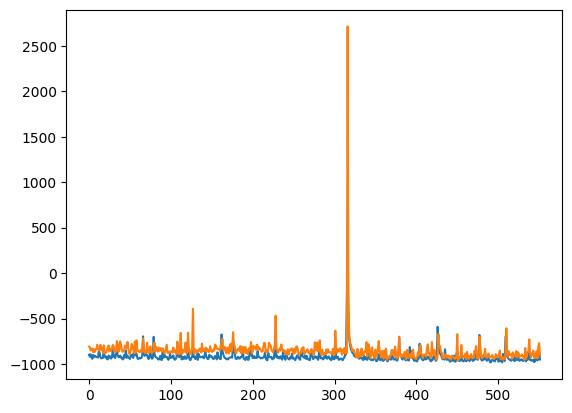

alpha 0.1 default_lr 0.0005


In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [40]:
print(datetime.datetime.now())

2023-07-27 21:59:35.000933


# Iter 5

In [41]:
policy_evaluation_iter=4

In [42]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [43]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.58081  validloss 0.79035±0.00000  bestvalidloss 0.79035  last_update 0
train: iter 1  trainloss 0.53706  validloss 0.55685±0.00000  bestvalidloss 0.55685  last_update 0
train: iter 2  trainloss 0.52386  validloss 0.55729±0.00000  bestvalidloss 0.55685  last_update 1
train: iter 3  trainloss 0.51715  validloss 0.55660±0.00000  bestvalidloss 0.55660  last_update 0
train: iter 4  trainloss 0.50852  validloss 0.53149±0.00000  bestvalidloss 0.53149  last_update 0
train: iter 5  trainloss 0.50083  validloss 0.54684±0.00000  bestvalidloss 0.53149  last_update 1
train: iter 6  trainloss 0.50166  validloss 0.52947±0.00000  bestvalidloss 0.52947  last_update 0
train: iter 7  trainloss 0.49563  validloss 0.53343±0.00000  bestvalidloss 0.52947  last_update 1
train: iter 8  trainloss 0.49123  validloss 0.53147±0.00000  bestvalidloss 0.52947  last_update 2
train: iter 9  trainloss 0.48790  validloss 0.52943±0.00000  bestvalidloss 0.52943  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.43340  validloss 0.50606±0.00000  bestvalidloss 0.48059  last_update 8
train: iter 84  trainloss 0.43160  validloss 0.49295±0.00000  bestvalidloss 0.48059  last_update 9
train: iter 85  trainloss 0.42975  validloss 0.49845±0.00000  bestvalidloss 0.48059  last_update 10
train: iter 86  trainloss 0.42558  validloss 0.48397±0.00000  bestvalidloss 0.48059  last_update 11
train: iter 87  trainloss 0.42741  validloss 0.48375±0.00000  bestvalidloss 0.48059  last_update 12
train: iter 88  trainloss 0.42541  validloss 0.49131±0.00000  bestvalidloss 0.48059  last_update 13
train: iter 89  trainloss 0.43404  validloss 0.48833±0.00000  bestvalidloss 0.48059  last_update 14
train: iter 90  trainloss 0.43038  validloss 0.50995±0.00000  bestvalidloss 0.48059  last_update 15
train: iter 91  trainloss 0.42566  validloss 0.49148±0.00000  bestvalidloss 0.48059  last_update 16
train: iter 92  trainloss 0.42814  validloss 0.49677±0.00000  bestvalidloss 0.48059  last_update 17
tr

train: iter 165  trainloss 0.41408  validloss 0.51139±0.00000  bestvalidloss 0.48059  last_update 90
train: iter 166  trainloss 0.40729  validloss 0.49438±0.00000  bestvalidloss 0.48059  last_update 91
train: iter 167  trainloss 0.40695  validloss 0.50589±0.00000  bestvalidloss 0.48059  last_update 92
train: iter 168  trainloss 0.41246  validloss 0.49302±0.00000  bestvalidloss 0.48059  last_update 93
train: iter 169  trainloss 0.40701  validloss 0.48820±0.00000  bestvalidloss 0.48059  last_update 94
train: iter 170  trainloss 0.40622  validloss 0.49750±0.00000  bestvalidloss 0.48059  last_update 95
train: iter 171  trainloss 0.40547  validloss 0.49053±0.00000  bestvalidloss 0.48059  last_update 96
train: iter 172  trainloss 0.41103  validloss 0.49581±0.00000  bestvalidloss 0.48059  last_update 97
train: iter 173  trainloss 0.40794  validloss 0.49839±0.00000  bestvalidloss 0.48059  last_update 98
train: iter 174  trainloss 0.40596  validloss 0.48396±0.00000  bestvalidloss 0.48059  last_

train_loss:  -6.156400341063739
valid_loss:  -7.180577224946022
weight_alpha 1.0 h_min_tilde -11.5817995 ell_tilde -6.361235717840195 kappa_tilde 0.0004376644750605526
train_loss:  -4.88637872018814
valid_loss:  -4.600749141311646
weight_alpha 0.1 h_min_tilde -11.5817995 ell_tilde -4.8292528044128415 kappa_tilde 0.0003848275906410364


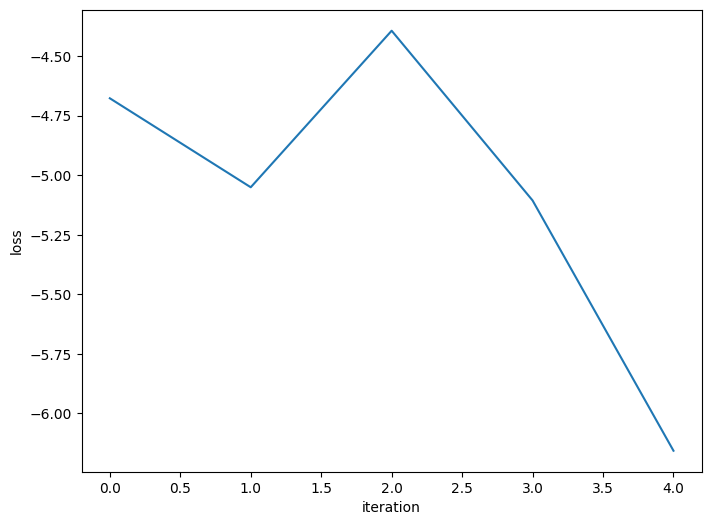

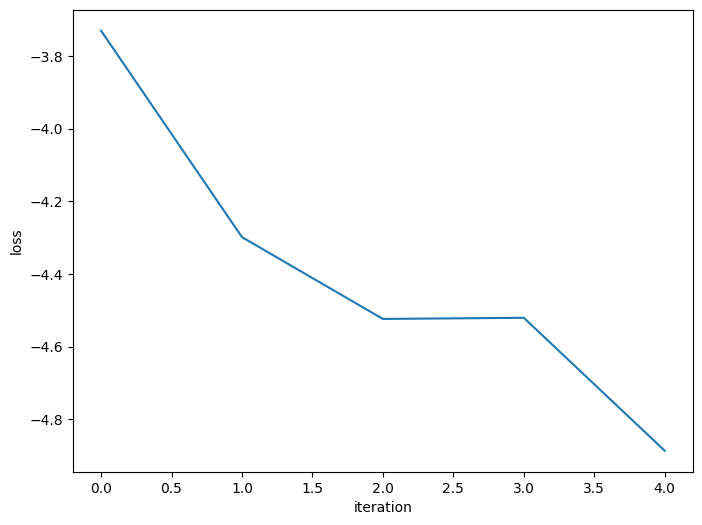

In [44]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [45]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -950.13165  validloss -917.11884±0.00000  bestvalidloss -917.11884  last_update 0
train: iter 1  trainloss -984.12426  validloss -907.76434±0.00000  bestvalidloss -917.11884  last_update 1
train: iter 2  trainloss -960.76770  validloss -896.36069±0.00000  bestvalidloss -917.11884  last_update 2
train: iter 3  trainloss -961.21164  validloss -776.47798±0.00000  bestvalidloss -917.11884  last_update 3
train: iter 4  trainloss -947.94194  validloss -904.56630±0.00000  bestvalidloss -917.11884  last_update 4
train: iter 5  trainloss -972.75520  validloss -917.18255±0.00000  bestvalidloss -917.18255  last_update 0
train: iter 6  trainloss -821.81824  validloss -857.72733±0.00000  bestvalidloss -917.18255  last_update 1
train: iter 7  trainloss -885.48596  validloss -874.53984±0.00000  bestvalidloss -917.18255  last_update 2
train: iter 8  trainloss -887.69999  validloss -730.96777±0.00000  bestvalidloss -917.18255  last_u

train: iter 76  trainloss -900.09488  validloss -863.46445±0.00000  bestvalidloss -938.75961  last_update 42
train: iter 77  trainloss -969.91107  validloss -882.01605±0.00000  bestvalidloss -938.75961  last_update 43
train: iter 78  trainloss -977.98901  validloss -916.65789±0.00000  bestvalidloss -938.75961  last_update 44
train: iter 79  trainloss -975.42005  validloss -897.57353±0.00000  bestvalidloss -938.75961  last_update 45
train: iter 80  trainloss -987.49621  validloss -909.25619±0.00000  bestvalidloss -938.75961  last_update 46
train: iter 81  trainloss -965.77633  validloss -862.69849±0.00000  bestvalidloss -938.75961  last_update 47
train: iter 82  trainloss -973.96097  validloss -879.82519±0.00000  bestvalidloss -938.75961  last_update 48
train: iter 83  trainloss -979.39996  validloss -881.94503±0.00000  bestvalidloss -938.75961  last_update 49
train: iter 84  trainloss -989.08589  validloss -899.47267±0.00000  bestvalidloss -938.75961  last_update 50
train: iter 85  tra

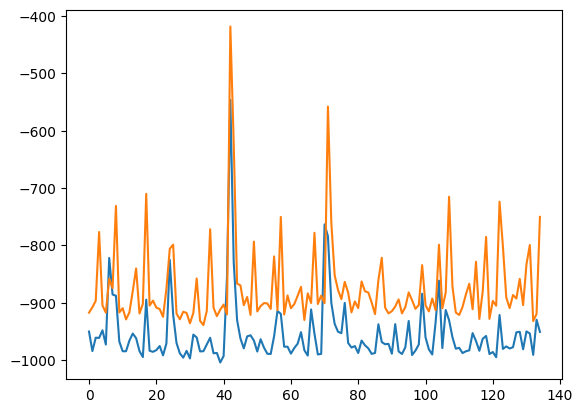

alpha 0.1 default_lr 0.0005


In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [47]:
print(datetime.datetime.now())

2023-07-27 22:23:25.853389


# 評価関数計算

In [48]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [49]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.54666  validloss 0.66070±0.00000  bestvalidloss 0.66070  last_update 0
train: iter 1  trainloss 0.51473  validloss 0.61818±0.00000  bestvalidloss 0.61818  last_update 0
train: iter 2  trainloss 0.51044  validloss 0.59827±0.00000  bestvalidloss 0.59827  last_update 0
train: iter 3  trainloss 0.49487  validloss 0.59792±0.00000  bestvalidloss 0.59792  last_update 0
train: iter 4  trainloss 0.49146  validloss 0.57409±0.00000  bestvalidloss 0.57409  last_update 0
train: iter 5  trainloss 0.48518  validloss 0.56711±0.00000  bestvalidloss 0.56711  last_update 0
train: iter 6  trainloss 0.48012  validloss 0.57303±0.00000  bestvalidloss 0.56711  last_update 1
train: iter 7  trainloss 0.47598  validloss 0.55476±0.00000  bestvalidloss 0.55476  last_update 0
train: iter 8  trainloss 0.47351  validloss 0.53630±0.00000  bestvalidloss 0.53630  last_update 0
train: iter 9  trainloss 0.47006  validloss 0.53683±0.00000  bestvalidloss 0.53630  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.41177  validloss 0.51433±0.00000  bestvalidloss 0.50545  last_update 60
train: iter 84  trainloss 0.41477  validloss 0.52844±0.00000  bestvalidloss 0.50545  last_update 61
train: iter 85  trainloss 0.41122  validloss 0.52512±0.00000  bestvalidloss 0.50545  last_update 62
train: iter 86  trainloss 0.41271  validloss 0.52325±0.00000  bestvalidloss 0.50545  last_update 63
train: iter 87  trainloss 0.41445  validloss 0.50822±0.00000  bestvalidloss 0.50545  last_update 64
train: iter 88  trainloss 0.40905  validloss 0.51598±0.00000  bestvalidloss 0.50545  last_update 65
train: iter 89  trainloss 0.40829  validloss 0.51470±0.00000  bestvalidloss 0.50545  last_update 66
train: iter 90  trainloss 0.41616  validloss 0.50501±0.00000  bestvalidloss 0.50501  last_update 0
train: iter 91  trainloss 0.40870  validloss 0.51007±0.00000  bestvalidloss 0.50501  last_update 1
train: iter 92  trainloss 0.40677  validloss 0.50160±0.00000  bestvalidloss 0.50160  last_update 0
tra

train: iter 165  trainloss 0.39419  validloss 0.50269±0.00000  bestvalidloss 0.49783  last_update 39
train: iter 166  trainloss 0.39446  validloss 0.51256±0.00000  bestvalidloss 0.49783  last_update 40
train: iter 167  trainloss 0.39416  validloss 0.50377±0.00000  bestvalidloss 0.49783  last_update 41
train: iter 168  trainloss 0.39670  validloss 0.50692±0.00000  bestvalidloss 0.49783  last_update 42
train: iter 169  trainloss 0.39288  validloss 0.51673±0.00000  bestvalidloss 0.49783  last_update 43
train: iter 170  trainloss 0.39390  validloss 0.50669±0.00000  bestvalidloss 0.49783  last_update 44
train: iter 171  trainloss 0.39606  validloss 0.52668±0.00000  bestvalidloss 0.49783  last_update 45
train: iter 172  trainloss 0.39662  validloss 0.50283±0.00000  bestvalidloss 0.49783  last_update 46
train: iter 173  trainloss 0.39484  validloss 0.51112±0.00000  bestvalidloss 0.49783  last_update 47
train: iter 174  trainloss 0.39188  validloss 0.53086±0.00000  bestvalidloss 0.49783  last_

train: iter 247  trainloss 0.38173  validloss 0.51044±0.00000  bestvalidloss 0.49656  last_update 56
train: iter 248  trainloss 0.38425  validloss 0.50564±0.00000  bestvalidloss 0.49656  last_update 57
train: iter 249  trainloss 0.38359  validloss 0.51177±0.00000  bestvalidloss 0.49656  last_update 58
train: iter 250  trainloss 0.38778  validloss 0.50650±0.00000  bestvalidloss 0.49656  last_update 59
train: iter 251  trainloss 0.38646  validloss 0.51079±0.00000  bestvalidloss 0.49656  last_update 60
train: iter 252  trainloss 0.38649  validloss 0.51027±0.00000  bestvalidloss 0.49656  last_update 61
train: iter 253  trainloss 0.38270  validloss 0.51885±0.00000  bestvalidloss 0.49656  last_update 62
train: iter 254  trainloss 0.38994  validloss 0.52033±0.00000  bestvalidloss 0.49656  last_update 63
train: iter 255  trainloss 0.38378  validloss 0.51215±0.00000  bestvalidloss 0.49656  last_update 64
train: iter 256  trainloss 0.38166  validloss 0.52297±0.00000  bestvalidloss 0.49656  last_

([0.5466619787737728,
  0.514731471799314,
  0.5104385064914823,
  0.4948740087449551,
  0.4914586689323187,
  0.4851774828508496,
  0.48012205278500913,
  0.47597592789679766,
  0.47351180482655764,
  0.4700603153556585,
  0.4660216700285673,
  0.4627846647053957,
  0.46324417563155296,
  0.4603251641616225,
  0.4632951566949487,
  0.4540992595255375,
  0.45597654581069946,
  0.45712829465046523,
  0.4512506818398833,
  0.4543723227456212,
  0.4527556146495044,
  0.45260692974552513,
  0.4513805224560201,
  0.45359744168817995,
  0.4540300818160176,
  0.44878863645717504,
  0.4474188956432045,
  0.4480345814488828,
  0.44580317120999097,
  0.44849502565339205,
  0.449670151527971,
  0.4463837460614741,
  0.4421521996147931,
  0.4293412923812866,
  0.4296110079623759,
  0.42565106274560094,
  0.43028733842074873,
  0.4258173161186278,
  0.42380514172837136,
  0.4277416566386819,
  0.4237638872116804,
  0.42044112738221884,
  0.42257579397410155,
  0.4221774055622518,
  0.42190672121942

In [50]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -4.411620449727774
valid_loss:  -4.9876013540506365
weight_alpha 1.0 h_min_tilde -11.531909 ell_tilde -4.5268166305923465 kappa_tilde 0.0003778270672214876
train_loss:  -4.311524257230759
valid_loss:  -3.835235102081299
weight_alpha 0.1 h_min_tilde -11.531909 ell_tilde -4.216266426200867 kappa_tilde 0.0003697206952145589


In [51]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 31.57459  validloss 33.22500±0.00000  bestvalidloss 33.22500  last_update 0
train: iter 1  trainloss 26.80111  validloss 28.14915±0.00000  bestvalidloss 28.14915  last_update 0
train: iter 2  trainloss 22.80845  validloss 23.77976±0.00000  bestvalidloss 23.77976  last_update 0
train: iter 3  trainloss 19.40933  validloss 20.30341±0.00000  bestvalidloss 20.30341  last_update 0
train: iter 4  trainloss 16.65197  validloss 17.48115±0.00000  bestvalidloss 17.48115  last_update 0
train: iter 5  trainloss 14.41989  validloss 14.89092±0.00000  bestvalidloss 14.89092  last_update 0
train: iter 6  trainloss 12.60618  validloss 12.98622±0.00000  bestvalidloss 12.98622  last_update 0
train: iter 7  trainloss 10.96176  validloss 11.38008±0.00000  bestvalidloss 11.38008  last_update 0
train: iter 8  trainloss 9.62065  validloss 9.80927±0.00000  bestvalidloss 9.80927  last_update 0
train: iter 9  trainloss 8.44603  validloss 8.51464±0.00000  bestvalidloss 8.51464  last_updat

train: iter 87  trainloss 0.68651  validloss 0.41048±0.00000  bestvalidloss 0.37167  last_update 25
train: iter 88  trainloss 0.68669  validloss 0.36380±0.00000  bestvalidloss 0.36380  last_update 0
train: iter 89  trainloss 0.69355  validloss 0.40295±0.00000  bestvalidloss 0.36380  last_update 1
train: iter 90  trainloss 0.68772  validloss 0.41153±0.00000  bestvalidloss 0.36380  last_update 2
train: iter 91  trainloss 0.70065  validloss 0.38930±0.00000  bestvalidloss 0.36380  last_update 3
train: iter 92  trainloss 0.69526  validloss 0.38232±0.00000  bestvalidloss 0.36380  last_update 4
train: iter 93  trainloss 0.69189  validloss 0.38035±0.00000  bestvalidloss 0.36380  last_update 5
train: iter 94  trainloss 0.67532  validloss 0.37416±0.00000  bestvalidloss 0.36380  last_update 6
train: iter 95  trainloss 0.69941  validloss 0.38423±0.00000  bestvalidloss 0.36380  last_update 7
train: iter 96  trainloss 0.68726  validloss 0.38561±0.00000  bestvalidloss 0.36380  last_update 8
train: it

train: iter 175  trainloss 0.68982  validloss 0.35343±0.00000  bestvalidloss 0.33546  last_update 17
train: iter 176  trainloss 0.66953  validloss 0.36115±0.00000  bestvalidloss 0.33546  last_update 18
train: iter 177  trainloss 0.69032  validloss 0.38332±0.00000  bestvalidloss 0.33546  last_update 19
train: iter 178  trainloss 0.67812  validloss 0.39030±0.00000  bestvalidloss 0.33546  last_update 20
train: iter 179  trainloss 0.69559  validloss 0.40689±0.00000  bestvalidloss 0.33546  last_update 21
train: iter 180  trainloss 0.67134  validloss 0.38993±0.00000  bestvalidloss 0.33546  last_update 22
train: iter 181  trainloss 0.69804  validloss 0.40136±0.00000  bestvalidloss 0.33546  last_update 23
train: iter 182  trainloss 0.69662  validloss 0.38305±0.00000  bestvalidloss 0.33546  last_update 24
train: iter 183  trainloss 0.68184  validloss 0.38818±0.00000  bestvalidloss 0.33546  last_update 25
train: iter 184  trainloss 0.69548  validloss 0.37918±0.00000  bestvalidloss 0.33546  last_

In [52]:
print(iwvi.initial_belief)


Parameter containing:
tensor([ 0.8438, -2.2000, -1.6229, -2.6916], requires_grad=True)


In [53]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 6.02102  validloss 13.93541±0.00000  bestvalidloss 13.93541  last_update 0
train: iter 1  trainloss 5.53235  validloss 14.88266±0.00000  bestvalidloss 13.93541  last_update 1
train: iter 2  trainloss 5.41132  validloss 14.17618±0.00000  bestvalidloss 13.93541  last_update 2
train: iter 3  trainloss 5.33366  validloss 14.14987±0.00000  bestvalidloss 13.93541  last_update 3
train: iter 4  trainloss 5.24449  validloss 15.09342±0.00000  bestvalidloss 13.93541  last_update 4
train: iter 5  trainloss 5.21862  validloss 14.29774±0.00000  bestvalidloss 13.93541  last_update 5
train: iter 6  trainloss 5.16235  validloss 13.83470±0.00000  bestvalidloss 13.83470  last_update 0
train: iter 7  trainloss 5.08735  validloss 13.71779±0.00000  bestvalidloss 13.71779  last_update 0
train: iter 8  trainloss 5.04855  validloss 14.08275±0.00000  bestvalidloss 13.71779  last_update 1
train: iter 9  trainloss 5.02640  validloss 13.68919±0.00000  bestvalidloss 13.68919  last_update 0


train: iter 83  trainloss 4.33421  validloss 14.21964±0.00000  bestvalidloss 13.29333  last_update 66
train: iter 84  trainloss 4.27279  validloss 13.83650±0.00000  bestvalidloss 13.29333  last_update 67
train: iter 85  trainloss 4.31558  validloss 13.94832±0.00000  bestvalidloss 13.29333  last_update 68
train: iter 86  trainloss 4.34020  validloss 13.69946±0.00000  bestvalidloss 13.29333  last_update 69
train: iter 87  trainloss 4.29702  validloss 14.55894±0.00000  bestvalidloss 13.29333  last_update 70
train: iter 88  trainloss 4.27844  validloss 14.99150±0.00000  bestvalidloss 13.29333  last_update 71
train: iter 89  trainloss 4.33147  validloss 14.10897±0.00000  bestvalidloss 13.29333  last_update 72
train: iter 90  trainloss 4.30183  validloss 14.62003±0.00000  bestvalidloss 13.29333  last_update 73
train: iter 91  trainloss 4.30490  validloss 14.45342±0.00000  bestvalidloss 13.29333  last_update 74
train: iter 92  trainloss 4.30279  validloss 14.06572±0.00000  bestvalidloss 13.29

In [54]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-5.6707)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(1.7022)


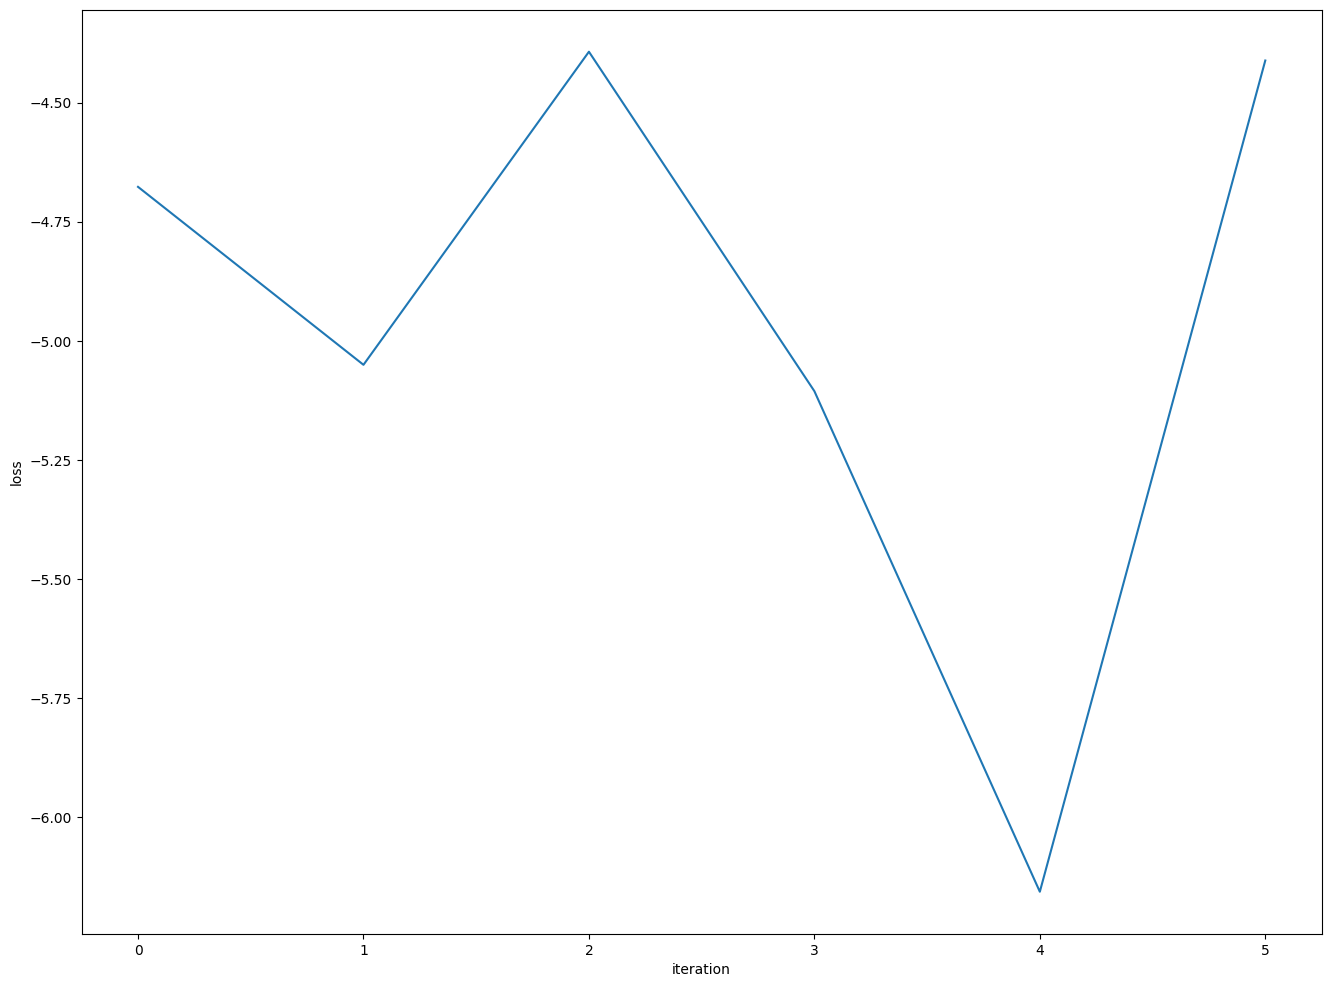

In [55]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

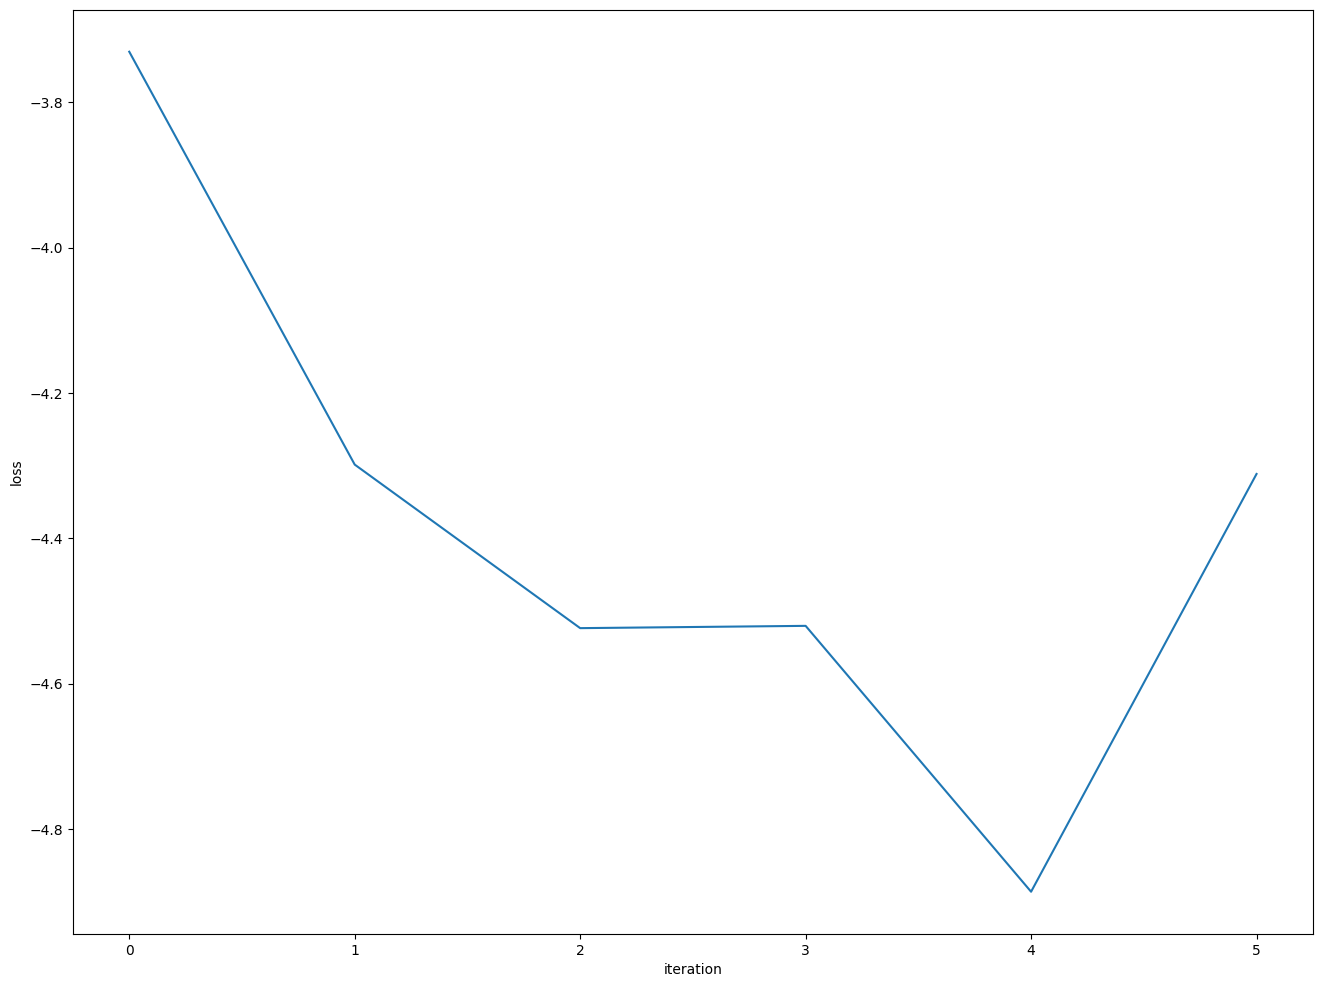

In [56]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")